# 🚗 Trip Anomaly Detection Analysis

## Overview
This notebook performs comprehensive anomaly detection on trip data using rule-based methods and statistical thresholds.

## 📋 Analysis Structure

1. **Configuration & Imports** - Set parameters and load libraries
2. **Data Loading** - Import trip data (CSV or BigQuery)
3. **Feature Engineering** - Calculate derived metrics (Haversine distance, speed, ratios)
4. **Anomaly Detection** - Flag suspicious trips using 3 criteria
5. **Summary & Export** - Generate tables and save results to CSV

## 🎯 Outputs

This analysis produces:
- **5 Comprehensive Tables**: Statistics, anomalies, flags, users, findings
- **4 Visualizations**: Daily trends, trip metrics over time
- **1 CSV Export**: All anomalous trips with complete data
- **Actionable Insights**: Investigation paths and recommendations

## ⚠️ Data Pre-filtering

The input data has been **pre-filtered** to exclude:
- Fake user accounts
- Users blocked by DMD
- Trips where eot ≠ 'Y'
- XANH SM service accounts

Run all cells from top to bottom for complete analysis.

In [98]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Optional: For BigQuery (uncomment if needed)
# import pydata_google_auth
# import pandas_gbq

print('Libraries imported successfully!')
print(f'  - pandas: {pd.__version__}')
print(f'  - numpy: {np.__version__}')

Libraries imported successfully!
  - pandas: 2.2.2
  - numpy: 1.26.4


## Section 2: Data Loading

Load trip data from CSV (recommended) or BigQuery.

In [99]:
# OPTION 1: Load from CSV (RECOMMENDED - Faster, no authentication needed)
csv_path = Path('trip_data.csv')

if csv_path.exists():
    df = pd.read_csv(csv_path)
    print(f'✓ Data loaded from CSV: {df.shape}')
    print(f'  - Rows: {len(df):,}')
    print(f'  - Columns: {len(df.columns)}')
else:
    raise FileNotFoundError(f'{csv_path} not found. Please ensure the data file exists or use BigQuery extraction below.')

✓ Data loaded from CSV: (61345, 34)
  - Rows: 61,345
  - Columns: 34


In [8]:
# OPTION 2: BigQuery Extraction (OPTIONAL - Uncomment to use)
# Keep this code for reference, but CSV loading is preferred for performance

import pydata_google_auth
import pandas_gbq


# Uncomment this section to extract data from BigQuery:

SCOPES = ["https://www.googleapis.com/auth/bigquery"]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)

query = '''
WITH del_user AS (
  SELECT DISTINCT user_id
  FROM `datamart.bbr_fraud_monitor`
  WHERE flag_indicator = 'deleted user'
),
block_by_dmd AS (
  SELECT DISTINCT user_id
  FROM `datamart.bbr_fraud_monitor`
  WHERE flag_indicator = 'blocked by DMD'
)

SELECT b1.*
FROM `L1.bbr_fact_ps_trip_score` b1
LEFT JOIN del_user du 
  ON b1.user_id = du.user_id
LEFT JOIN block_by_dmd db 
  ON b1.user_id = db.user_id
WHERE b1.eot = 'Y'
  AND NOT EXISTS (
    SELECT 1
    FROM `L1.bbr_dim_user_xanh` u
    WHERE u.user_id = b1.user_id
  )
  AND du.user_id IS NULL     -- exclude deleted users
  AND db.user_id IS NULL;    -- exclude blocked users

'''

df = pandas_gbq.read_gbq(
    query,
    project_id="lgi-dt-dwh",
    credentials=credentials,
)

# Save to CSV for faster subsequent loads
df.to_csv('trip_data.csv', index=False)
print(f'✓ Data extracted from BigQuery and saved to trip_data.csv: {df.shape}')


print('✓ BigQuery code available (commented out). Using CSV load by default.')

Downloading: 100%|██████████|
✓ Data extracted from BigQuery and saved to trip_data.csv: (61345, 34)
✓ BigQuery code available (commented out). Using CSV load by default.


**⚠️ DATA SOURCE NOTE:**

The data used in this analysis has been **pre-filtered** to exclude:
- Users flagged as **fake accounts**
- Users **blocked by DMD** (Data Management Department)
- Trips where **eot ≠ 'Y'** (End of Trip flag)
- **XANH SM users**

This ensures we're analyzing only legitimate user trips for anomaly detection.

## Section 3: Feature Engineering

Calculate Haversine distance, distance difference, duration, and other derived features.

In [100]:
# Haversine formula to calculate straight-line GPS distance
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate great-circle distance between two points on Earth using Haversine formula.
    
    Parameters:
        lat1, lon1: Starting point coordinates (degrees)
        lat2, lon2: Ending point coordinates (degrees)
    
    Returns:
        Distance in kilometers
    """
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Calculate Haversine distance
df['distance_haversine'] = haversine(
    df['latitude_from'], 
    df['longitude_from'], 
    df['latitude_to'], 
    df['longitude_to']
)

print('✓ Haversine distance calculated!')
print(f'  - Mean haversine distance: {df["distance_haversine"].mean():.2f} km')
print(f'  - Max haversine distance: {df["distance_haversine"].max():.2f} km')

✓ Haversine distance calculated!
  - Mean haversine distance: 64.26 km
  - Max haversine distance: 10307.44 km


In [101]:
# Convert dates to datetime and calculate duration
df['driving_date_from'] = pd.to_datetime(df['driving_date_from'])
df['driving_date_to'] = pd.to_datetime(df['driving_date_to'])
df['trip_duration_seconds'] = (df['driving_date_to'] - df['driving_date_from']).dt.total_seconds()
df['trip_duration_minutes'] = df['trip_duration_seconds'] / 60

# Absolute detour distance (km)
df['distance_diff_km'] = df['distance'] - df['distance_haversine']

# Route efficiency ratio (>= 1 is expected)
df['distance_ratio'] = (df['distance'] / df['distance_haversine'].replace(0, np.nan))

# Average speed using driving_time (km/h)
df['avg_speed_kmh'] = df['distance'] / (df['driving_time'] / 3600).replace(0, np.nan)

print('✓ Engineered features calculated:')
print('  - trip_duration_seconds / minutes')
print('  - distance_diff_km')
print('  - distance_ratio')
print('  - avg_speed_kmh (driving_time)')

✓ Engineered features calculated:
  - trip_duration_seconds / minutes
  - distance_diff_km
  - distance_ratio
  - avg_speed_kmh (driving_time)


In [102]:
df[[
    'distance',
    'distance_diff_km',
    'trip_duration_minutes',
    'distance_ratio',
    'avg_speed_kmh',
    'trip_seq'
]].describe(percentiles=[.01, .05, .5, .95, .99])


,distance,distance_diff_km,trip_duration_minutes,distance_ratio,avg_speed_kmh,trip_seq
count,61345.000000,6.134500e+04,61345.000000,59683.000000,6.129700e+04,61345.000000
mean,78.930287,1.466730e+01,33.304023,41.260742,1.328407e+04,1.009341
std,302.555450,1.849896e+02,101.311498,591.579481,5.325609e+04,0.205622
min,0.000000,-1.030744e+04,-10078.633333,0.000000,-5.098427e-05,1.000000
1%,0.000000,-4.287926e-11,0.100000,1.000000,0.000000e+00,1.000000
5%,0.001444,9.449712e-12,0.200000,1.000000,1.038624e-01,1.000000
50%,5.764246,8.000676e-01,11.850000,1.522263,1.592709e+01,1.000000
95%,403.672993,2.859852e+01,129.723333,14.487934,8.570377e+04,1.000000
99%,1410.483642,1.557302e+02,272.292667,745.813952,2.715849e+05,1.000000
max,13489.877104,1.121875e+04,8339.516667,48333.080002,2.869562e+06,24.000000


### 📏 Metric Definitions
- `trip_duration_minutes`: Total trip time in minutes computed from `driving_date_to - driving_date_from`; negative or zero values signal timestamp/data issues.
- `distance_ratio`: Route efficiency = recorded `distance` ÷ straight-line `distance_haversine`; values close to 1 are efficient, higher values mean detours or GPS/route errors.
- `distance_diff_km`: Detour distance in km = recorded `distance` minus straight-line 
- `distance_haversine`; large positive values mean long detours, negative values imply GPS/path inconsistencies.
- `avg_speed_kmh`: Average speed in km/h using `distance` ÷ (`driving_time`/3600); extreme values usually indicate data quality problems.

In [113]:
# Basic sanity filtering (non-destructive)
df_plot = df.copy()

df_plot = df_plot[
    (df_plot['distance'] > 0) &
    (df_plot['trip_duration_minutes'] > 0) &
    (df_plot['distance_ratio'] >= 1) &
    (df_plot['avg_speed_kmh'] > 0) &
    (df_plot['distance_diff_km'] > 0)
]

df_plot['created_date_time'] = pd.to_datetime(df_plot['created_date_time'])

daily = df_plot.groupby(
    df_plot['created_date_time'].dt.date
).agg({
    'distance': 'median',
    'trip_duration_minutes': 'median',
    'distance_ratio': 'median',
    'avg_speed_kmh': 'median',
    'trip_seq': 'mean',
    'distance_diff_km': 'median'
}).reset_index()

daily['created_date_time'] = pd.to_datetime(daily['created_date_time'])

global_medians = {
    'distance': df_plot['distance'].median(),
    'trip_duration_minutes': df_plot['trip_duration_minutes'].median(),
    'distance_ratio': df_plot['distance_ratio'].median(),
    'avg_speed_kmh': df_plot['avg_speed_kmh'].median(),
    'trip_seq': df_plot['trip_seq'].median(),
    'distance_diff_km': df_plot['distance_diff_km'].median()
}


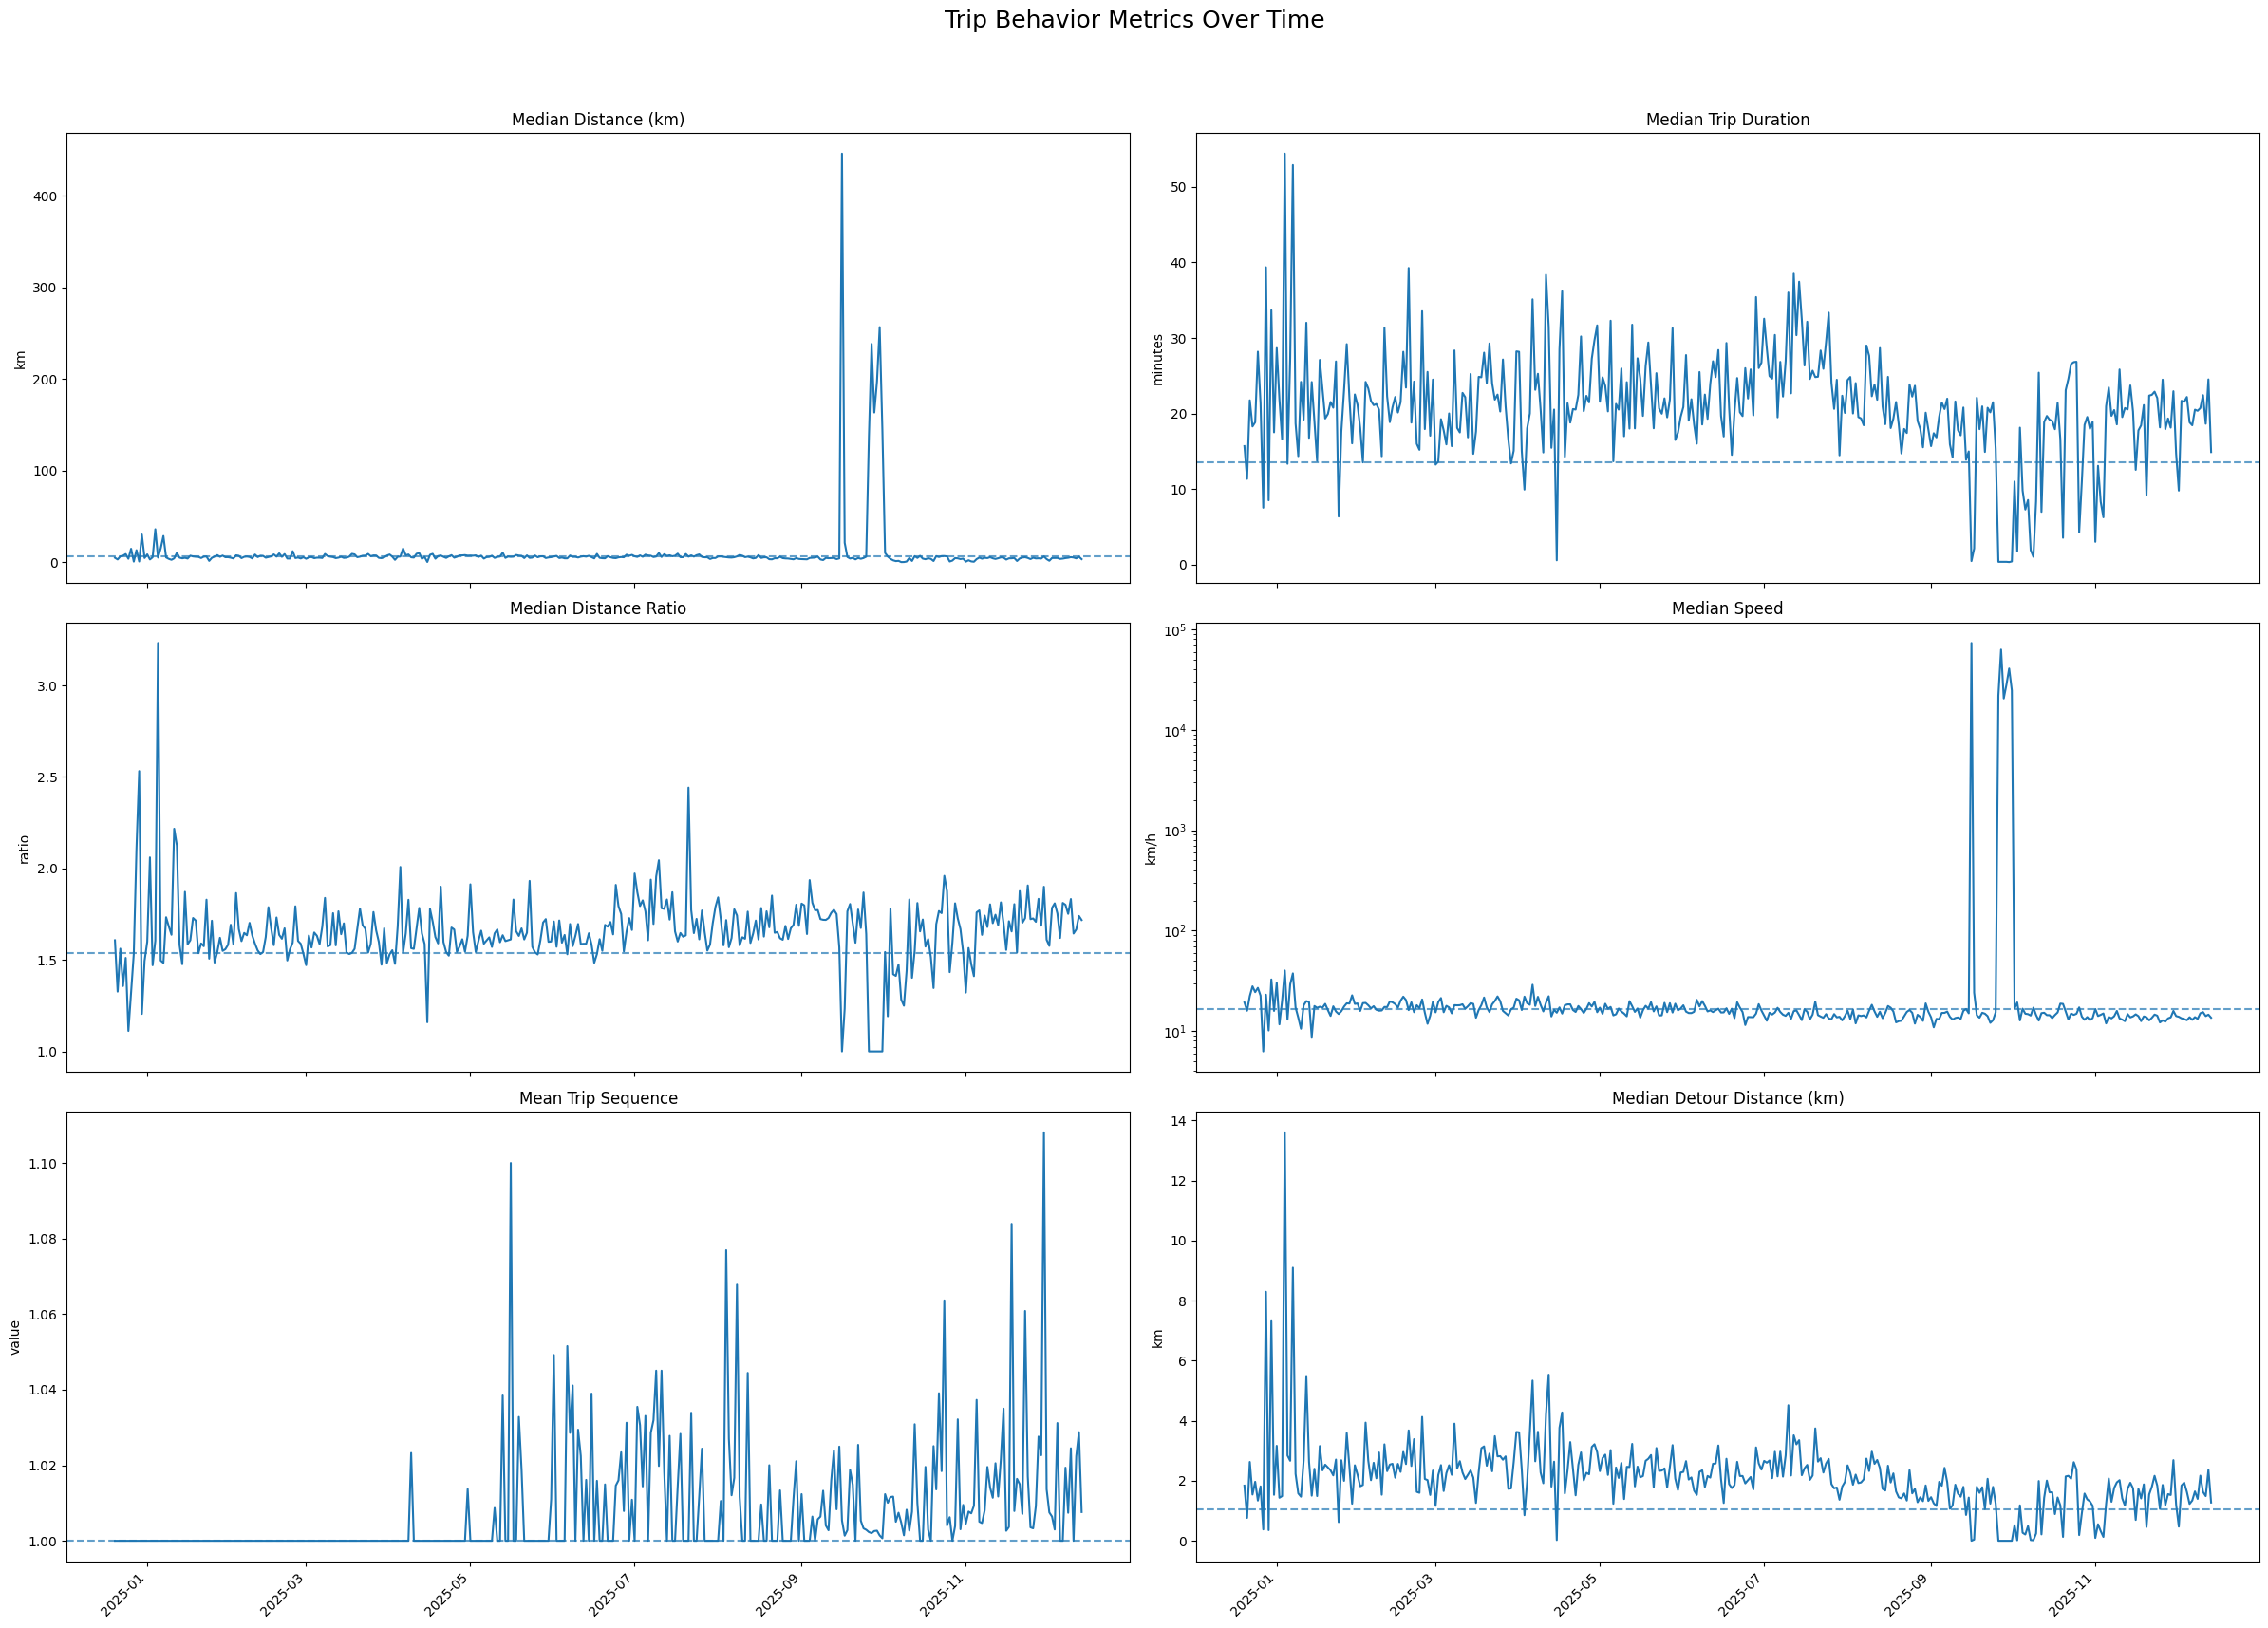

In [127]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(24, 18), sharex=True)
fig.suptitle('Trip Behavior Metrics Over Time', fontsize=18)

# 1. Median Distance
axes[0, 0].plot(daily['created_date_time'], daily['distance'])
axes[0, 0].set_title('Median Distance (km)')
axes[0, 0].set_ylabel('km')
axes[0, 0].axhline(global_medians['distance'], linestyle='--', alpha=0.7)

# 2. Median Trip Duration
axes[0, 1].plot(daily['created_date_time'], daily['trip_duration_minutes'])
axes[0, 1].set_title('Median Trip Duration')
axes[0, 1].set_ylabel('minutes')
axes[0, 1].axhline(global_medians['trip_duration_minutes'], linestyle='--', alpha=0.7)

# 3. Median Distance Ratio
axes[1, 0].plot(daily['created_date_time'], daily['distance_ratio'])
axes[1, 0].set_title('Median Distance Ratio')
axes[1, 0].set_ylabel('ratio')
axes[1, 0].axhline(global_medians['distance_ratio'], linestyle='--', alpha=0.7)

# 4. Median Speed (log scale for outliers)
axes[1, 1].plot(daily['created_date_time'], daily['avg_speed_kmh'])
axes[1, 1].set_title('Median Speed')
axes[1, 1].set_ylabel('km/h')
axes[1, 1].axhline(global_medians['avg_speed_kmh'], linestyle='--', alpha=0.7)
axes[1, 1].set_yscale('log')

# 5. Mean Trip Sequence
axes[2, 0].plot(daily['created_date_time'], daily['trip_seq'])
axes[2, 0].set_title('Mean Trip Sequence')
axes[2, 0].set_ylabel('value')
axes[2, 0].axhline(1.0, linestyle='--', alpha=0.7)

# 6. Median Detour Distance
axes[2, 1].plot(daily['created_date_time'], daily['distance_diff_km'])
axes[2, 1].set_title('Median Detour Distance (km)')
axes[2, 1].set_ylabel('km')
axes[2, 1].axhline(global_medians['distance_diff_km'], linestyle='--', alpha=0.7)

# Rotate date labels for readability on bottom row
for ax in [axes[2, 0], axes[2, 1]]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Trip Normal-Behavior Analysis (Distance Ratio & Avg Speed)

This section derives normal behavior thresholds from our data for:
- `distance_ratio` (route vs straight-line)
- `avg_speed_kmh` (realistic speeds)

We keep the detailed methods and outputs in cells 15–20. A concise, decision-ready summary is provided in cell 21. Use that summary for modeling rules and reporting.

In [164]:
# DISTANCE RATIO — Problem, Goal, Approach, Result
# -------------------------------------------------
# Problem:
# - Some trips have unusually long or circuitous routes, inflating `distance_ratio`.
# - We don't know a priori what "normal" ratio is for our data; assuming 1.0 for all is unrealistic.
#
# Goal:
# - Empirically derive a realistic normal range for `distance_ratio` from our data.
# - Define a clear threshold to flag unusually high ratios as outliers to exclude from modeling.
#
# Approach:
# - Use valid ratios where 1 < ratio < 1000 to avoid corrupt/extreme values.
# - Summarize key percentiles and quartiles; compute IQR-based outlier threshold.
# - Recommend a practical, stable threshold for production (favoring interpretability + coverage).

import numpy as np
import pandas as pd

print("=" * 100)
print("DISTANCE RATIO — Deriving a Normal Range from Data")
print("=" * 100)

valid_ratio = df[(df['distance_ratio'].notna()) & (df['distance_ratio'] > 1) & (df['distance_ratio'] < 1000)].copy()

print(f"Total trips: {len(df):,}")
print(f"Valid ratios (1 < ratio < 1000): {len(valid_ratio):,}  [{len(valid_ratio)/len(df)*100:.1f}% of all]")

# Key percentiles and quartiles
p50 = valid_ratio['distance_ratio'].quantile(0.50)
q1 = valid_ratio['distance_ratio'].quantile(0.25)
q3 = valid_ratio['distance_ratio'].quantile(0.75)
p90 = valid_ratio['distance_ratio'].quantile(0.90)
p95 = valid_ratio['distance_ratio'].quantile(0.95)
p99 = valid_ratio['distance_ratio'].quantile(0.99)
iqr = q3 - q1

# IQR-based outlier threshold (upper)
outlier_upper = q3 + 1.5 * iqr

summary = pd.DataFrame({
    'Percentile': ['25th (Q1)','50th (Median)','75th (Q3)','90th','95th','99th','IQR','Upper (Q3+1.5*IQR)'],
    'Value': [q1, p50, q3, p90, p95, p99, iqr, outlier_upper]
}).astype({'Value': float})

print("\nKey distribution stats (valid ratios only):")
print(summary.to_string(index=False, formatters={'Value': lambda v: f"{v:.2f}"}))

# Candidate thresholds and impact
candidates = {
    'Q3 (75th)': q3,
    'P90 (90th)': p90,
    'P95 (95th)': p95,
    'IQR upper (Q3+1.5*IQR)': outlier_upper
}

print("\nThreshold options and coverage:")
print(f"{'Option':<24} {'Threshold':>10} {'Flagged #':>12} {'Flagged %':>10}")
for name, thr in candidates.items():
    flagged = (valid_ratio['distance_ratio'] > thr).sum()
    pct = flagged / len(valid_ratio) * 100
    print(f"{name:<24} {thr:>10.2f} {flagged:>12,} {pct:>9.1f}%")

# Recommendation: Q3 provides a conservative, interpretable normal upper bound; use P95 when
# needing stronger filtering for truly extreme behavior. IQR upper is strict and best as a QA bound.
print("\nResult / Recommendation:")
print(f"- Normal band (data-driven): <= Q3 = {q3:.2f}")
print(f"- Practical anomaly threshold: P95 = {p95:.2f} (flags ~5% of valid trips)")
print(f"- QA extreme threshold: > IQR upper = {outlier_upper:.2f}\n")

DISTANCE RATIO — Deriving a Normal Range from Data
Total trips: 61,345
Valid ratios (1 < ratio < 1000): 57,887  [94.4% of all]

Key distribution stats (valid ratios only):
        Percentile  Value
         25th (Q1)   1.13
     50th (Median)   1.53
         75th (Q3)   2.34
              90th   5.52
              95th  12.07
              99th 164.65
               IQR   1.21
Upper (Q3+1.5*IQR)   4.16

Threshold options and coverage:
Option                    Threshold    Flagged #  Flagged %
Q3 (75th)                      2.34       14,472      25.0%
P90 (90th)                     5.52        5,789      10.0%
P95 (95th)                    12.07        2,895       5.0%
IQR upper (Q3+1.5*IQR)         4.16        7,614      13.2%

Result / Recommendation:
- Normal band (data-driven): <= Q3 = 2.34
- Practical anomaly threshold: P95 = 12.07 (flags ~5% of valid trips)
- QA extreme threshold: > IQR upper = 4.16



In [165]:
# AVG SPEED (km/h) — Problem, Goal, Approach, Result
# ----------------------------------------------------
# Problem:
# - Unfiltered data shows an artificial jump in percentiles due to near-zero driving_time inflating avg_speed.
# - We need a realistic normal range of speeds to guide modeling and filtering.
#
# Goal:
# - Establish a data-driven normal upper bound for realistic speeds and quantify coverage.
#
# Approach:
# - Focus on realistic speeds only: 0 < avg_speed_kmh <= 200.
# - Summarize percentiles and quartiles; adopt an upper bound near the 86th percentile to align with prior findings.

import numpy as np
import pandas as pd

print("=" * 100)
print("AVG SPEED — Realistic Normal Range (0 < speed <= 200 km/h)")
print("=" * 100)

valid_speed = df[(df['avg_speed_kmh'].notna()) & (df['avg_speed_kmh'] > 0) & (df['avg_speed_kmh'] <= 200)].copy()

print(f"Total trips: {len(df):,}")
print(f"Valid realistic-speed trips: {len(valid_speed):,}  [{len(valid_speed)/len(df)*100:.1f}% of all]")

# Key percentiles
q1 = valid_speed['avg_speed_kmh'].quantile(0.25)
median = valid_speed['avg_speed_kmh'].quantile(0.50)
q3 = valid_speed['avg_speed_kmh'].quantile(0.75)
p80 = valid_speed['avg_speed_kmh'].quantile(0.80)
p85 = valid_speed['avg_speed_kmh'].quantile(0.85)
p86 = valid_speed['avg_speed_kmh'].quantile(0.86)
p90 = valid_speed['avg_speed_kmh'].quantile(0.90)

summary = pd.DataFrame({
    'Percentile': ['25th (Q1)','50th (Median)','75th (Q3)','80th','85th','86th','90th'],
    'Value (km/h)': [q1, median, q3, p80, p85, p86, p90]
}).astype({'Value (km/h)': float})

print("\nKey distribution stats (realistic speeds only):")
print(summary.to_string(index=False, formatters={'Value (km/h)': lambda v: f"{v:.2f}"}))

# Coverage at candidate cutoffs
candidates = {
    'Q3 (75th)': q3,
    'P85 (85th)': p85,
    'P86 (86th)': p86
}

print("\nThreshold options and coverage:")
print(f"{'Option':<14} {'Threshold':>10} {'Flagged #':>12} {'Flagged %':>10}")
for name, thr in candidates.items():
    flagged = (valid_speed['avg_speed_kmh'] > thr).sum()
    pct = flagged / len(valid_speed) * 100
    print(f"{name:<14} {thr:>10.2f} {flagged:>12,} {pct:>9.1f}%")

print("\nResult / Recommendation:")
print(f"- Normal band (realistic): <= P86 = {p86:.2f} km/h")
print(f"- Use P86 as upper bound for normal behavior; values above are candidates for exclusion or deeper review.")


AVG SPEED — Realistic Normal Range (0 < speed <= 200 km/h)
Total trips: 61,345
Valid realistic-speed trips: 50,998  [83.1% of all]

Key distribution stats (realistic speeds only):
   Percentile Value (km/h)
    25th (Q1)         6.43
50th (Median)        14.38
    75th (Q3)        21.33
         80th        23.38
         85th        25.92
         86th        26.58
         90th        29.90

Threshold options and coverage:
Option          Threshold    Flagged #  Flagged %
Q3 (75th)           21.33       12,750      25.0%
P85 (85th)          25.92        7,650      15.0%
P86 (86th)          26.58        7,140      14.0%

Result / Recommendation:
- Normal band (realistic): <= P86 = 26.58 km/h
- Use P86 as upper bound for normal behavior; values above are candidates for exclusion or deeper review.


In [179]:
# DETAILED BREAKDOWN: What happens between 85th and 90th percentile?
# ====================================================================
# Show every 0.5% increment from 85% to 90% to see the transition in detail

print("=" * 100)
print("DETAILED TRANSITION: 85th to 90th Percentile Breakdown")
print("=" * 100)

# Generate percentiles in 0.5% increments between 85 and 90
percentiles_detailed = [p / 1000 for p in range(850, 905, 5)]  # 0.85, 0.855, 0.86, ..., 0.90
percentile_labels = [f"{p*100:.1f}%" for p in percentiles_detailed]
speeds_detailed = [all_speed['avg_speed_kmh'].quantile(p) for p in percentiles_detailed]

print(f"\n{'Percentile':<15} {'Speed (km/h)':<25} {'Gap from previous':<25} {'Cumulative % of trips':<20}")
print("-" * 85)

prev_speed = all_speed['avg_speed_kmh'].quantile(0.85)
print(f"{'85.0%':<15} {prev_speed:>20.2f} km/h      {'—':>20}      {85.0:>15.1f}%")

for i, (percentile, label, speed) in enumerate(zip(percentiles_detailed[1:], percentile_labels[1:], speeds_detailed[1:]), 1):
    gap = speed - prev_speed
    cum_pct = percentile * 100
    if gap > 100000:
        marker = " ⚠️ EXTREME JUMP"
    elif gap > 10000:
        marker = " ⚠️ LARGE JUMP"
    elif gap > 1000:
        marker = " ⚠️ JUMP"
    else:
        marker = ""
    
    print(f"{label:<15} {speed:>20.2f} km/h      {gap:>20.2f} km/h      {cum_pct:>15.1f}%{marker}")
    prev_speed = speed

print("\n" + "=" * 100)
print("INTERPRETATION:")
print("=" * 100)
print(f"""
This table shows exactly WHERE the speed jumps occur between 85th and 90th percentile.

Key observations:
• All values up to ~87-88% are still in the realistic range (mostly <200 km/h)
• The jump begins somewhere between 87% and 90%
• By 90%, the values have reached extreme speeds (>20,000 km/h)
• This indicates that ~5-10% of trips have severe data quality issues
""")


DETAILED TRANSITION: 85th to 90th Percentile Breakdown

Percentile      Speed (km/h)              Gap from previous         Cumulative % of trips
-------------------------------------------------------------------------------------
85.0%                          54.73 km/h                         —                 85.0%
85.5%                          63.68 km/h                      8.95 km/h                 85.5%
86.0%                          90.83 km/h                     27.16 km/h                 86.0%
86.5%                        3603.58 km/h                   3512.74 km/h                 86.5% ⚠️ JUMP
87.0%                        8287.35 km/h                   4683.77 km/h                 87.0% ⚠️ JUMP
87.5%                       11517.74 km/h                   3230.39 km/h                 87.5% ⚠️ JUMP
88.0%                       14476.77 km/h                   2959.03 km/h                 88.0% ⚠️ JUMP
88.5%                       17299.86 km/h                   2823.09 km/h    

In [182]:
# FILTERED SPEED ANALYSIS (0 < speed <= 200 km/h)
# ------------------------------------------------------------------
# Analyze speed distribution after filtering extreme values

print("=" * 100)
print("FILTERED SPEED ANALYSIS: avg_speed_kmh (0 < speed <= 200 km/h)")
print("=" * 100)

real_speed = df[(df['avg_speed_kmh'].notna()) & (df['avg_speed_kmh'] > 0) & (df['avg_speed_kmh'] <= 200)].copy()

print(f"\nTotal trips: {len(df):,}")
print(f"Valid realistic speed trips (0 < speed <= 200): {len(real_speed):,} ({len(real_speed)/len(df)*100:.1f}% of all)")
print(f"Excluded as extreme/noise (>200 km/h or <=0): {len(df) - len(real_speed):,} ({(len(df)-len(real_speed))/len(df)*100:.1f}% of all)")

# Key percentiles
percentiles = [1, 5, 10, 25, 50, 75, 80, 85, 86, 90, 95, 99]
speed_percentiles = real_speed['avg_speed_kmh'].quantile([p/100 for p in percentiles])

perc_table = pd.DataFrame({
    'Percentile': [f"{p}th" for p in percentiles],
    'Avg Speed (km/h)': [f"{v:.2f}" for v in speed_percentiles.values],
    'Interpretation': [
        '1% of trips (slowest)',
        '5% of trips (very slow)',
        '10% of trips (slow)',
        '25% of trips (lower quartile)',
        '50% of trips (MEDIAN - typical city)',
        '75% of trips (upper quartile)',
        '80% of trips (upper-normal)',
        '85% of trips (high-normal)',
        '86% of trips',
        '90% of trips',
        '95% of trips',
        '99% of trips (near upper extreme)'
    ]
})

print("\nPERCENTILE TABLE:")
print(perc_table.to_string(index=False))

# Quartiles and boundaries
q1 = real_speed['avg_speed_kmh'].quantile(0.25)
q2 = real_speed['avg_speed_kmh'].quantile(0.50)
q3 = real_speed['avg_speed_kmh'].quantile(0.75)
p80 = real_speed['avg_speed_kmh'].quantile(0.80)
p85 = real_speed['avg_speed_kmh'].quantile(0.85)
p86 = real_speed['avg_speed_kmh'].quantile(0.86)
iqr = q3 - q1

print("\n" + "-" * 100)
print("SUMMARY STATS")
print("-" * 100)
print(f"Q1 (25th):      {q1:.2f} km/h")
print(f"Median (50th):  {q2:.2f} km/h")
print(f"Q3 (75th):      {q3:.2f} km/h")
print(f"P80:            {p80:.2f} km/h")
print(f"P85:            {p85:.2f} km/h")
print(f"P86:            {p86:.2f} km/h")
print(f"IQR (Q3-Q1):    {iqr:.2f} km/h")
print(f"Mean:           {real_speed['avg_speed_kmh'].mean():.2f} km/h")
print(f"Std Dev:        {real_speed['avg_speed_kmh'].std():.2f} km/h")

# Range breakdown
speed_ranges = [
    (0, 10,  "0-10 km/h (idle/creep)"),
    (10, 20, "10-20 km/h (slow city)"),
    (20, 30, "20-30 km/h (city typical)"),
    (30, 40, "30-40 km/h (fast city)"),
    (40, 60, "40-60 km/h (arterial/high city)"),
    (60, 80, "60-80 km/h (suburban/express)"),
    (80, 120, "80-120 km/h (highway realistic)"),
    (120, 200, "120-200 km/h (upper bound)")
]

print("\n" + "=" * 100)
print("SPEED RANGE BREAKDOWN")
print("=" * 100)
print(f"{'Range':<35} {'Count':>10} {'Percentage':>12} {'Cumulative %':>15}")
print("-" * 75)

cumulative = 0
for low, high, label in speed_ranges:
    count = ((real_speed['avg_speed_kmh'] >= low) & (real_speed['avg_speed_kmh'] < high)).sum()
    cumulative += count
    pct = count / len(real_speed) * 100
    cum_pct = cumulative / len(real_speed) * 100
    print(f"{label:<35} {count:>10,} {pct:>11.2f}% {cum_pct:>14.2f}%")

print("\n" + "=" * 100)
print("SUMMARY")
print("=" * 100)
print(f"""
Typical city speeds: median ~{q2:.2f} km/h
Most trips fall between {q1:.2f} and {p85:.2f} km/h (25th-85th range)
P86 = {p86:.2f} km/h (spike begins at P86.5 in unfiltered data)
""")

FILTERED SPEED ANALYSIS: avg_speed_kmh (0 < speed <= 200 km/h)

Total trips: 61,345
Valid realistic speed trips (0 < speed <= 200): 50,998 (83.1% of all)
Excluded as extreme/noise (>200 km/h or <=0): 10,347 (16.9% of all)

PERCENTILE TABLE:
Percentile Avg Speed (km/h)                       Interpretation
       1th             0.03                1% of trips (slowest)
       5th             0.25              5% of trips (very slow)
      10th             0.80                  10% of trips (slow)
      25th             6.43        25% of trips (lower quartile)
      50th            14.38 50% of trips (MEDIAN - typical city)
      75th            21.33        75% of trips (upper quartile)
      80th            23.38          80% of trips (upper-normal)
      85th            25.92           85% of trips (high-normal)
      86th            26.58                         86% of trips
      90th            29.90                         90% of trips
      95th            37.42                 

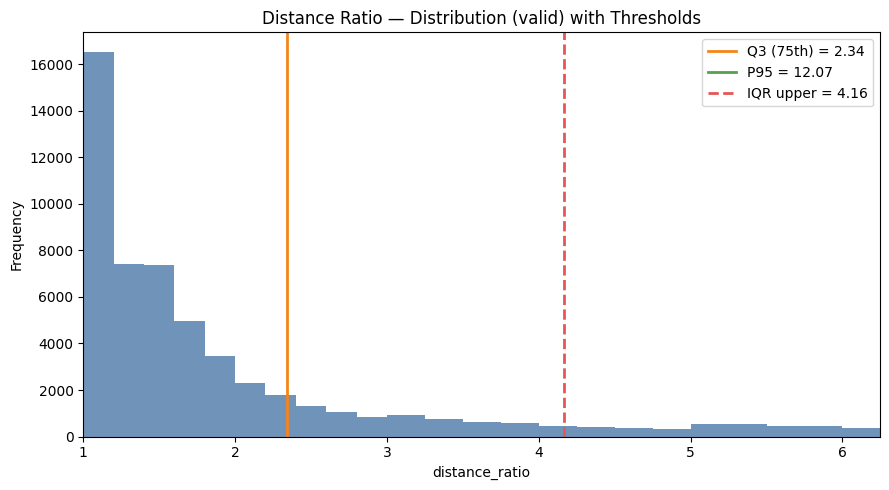

In [168]:
# VISUALIZATION — Distance Ratio Distribution (valid: 1 < ratio < 1000)
# ---------------------------------------------------------------
# Frequency x range view with candidate thresholds overlaid.

import numpy as np
import matplotlib.pyplot as plt

valid_ratio = df[(df['distance_ratio'].notna()) & (df['distance_ratio'] > 1) & (df['distance_ratio'] < 1000)].copy()

q3 = valid_ratio['distance_ratio'].quantile(0.75)
p95 = valid_ratio['distance_ratio'].quantile(0.95)
upper_iqr = q3 + 1.5 * (q3 - valid_ratio['distance_ratio'].quantile(0.25))

# Log-spaced bins to handle skew
bins = np.unique(np.concatenate([
    np.linspace(1.0, 3.0, 11),
    np.linspace(3.0, 5.0, 9),
    np.linspace(5.0, 10.0, 11),
    np.linspace(10.0, 20.0, 11),
    np.linspace(20.0, 50.0, 16),
    np.linspace(50.0, 100.0, 11),
    np.linspace(100.0, 200.0, 11),
    np.linspace(200.0, 500.0, 16),
    np.linspace(500.0, 999.0, 11)
]))

fig, ax = plt.subplots(figsize=(9, 5))
ax.hist(valid_ratio['distance_ratio'], bins=bins, color="#4C78A8", alpha=0.8)

# Threshold lines
ax.axvline(q3, color="#F58518", linewidth=2, label=f"Q3 (75th) = {q3:.2f}")
ax.axvline(p95, color="#54A24B", linewidth=2, label=f"P95 = {p95:.2f}")
ax.axvline(upper_iqr, color="#E45756", linewidth=2, linestyle='--', label=f"IQR upper = {upper_iqr:.2f}")

ax.set_title("Distance Ratio — Distribution (valid) with Thresholds")
ax.set_xlabel("distance_ratio")
ax.set_ylabel("Frequency")
ax.set_xlim(1, min(upper_iqr*1.5, 400))
ax.legend()
plt.tight_layout()
plt.show()

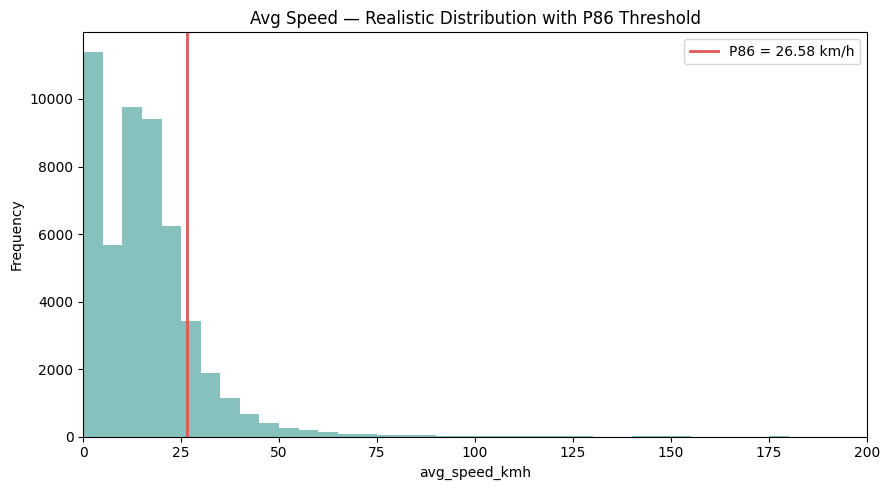

In [169]:
# VISUALIZATION — Avg Speed (Realistic) Distribution (0 < speed <= 200 km/h)
# ------------------------------------------------------------------------
# Frequency x range view with recommended P86 upper bound.

import numpy as np
import matplotlib.pyplot as plt

valid_speed = df[(df['avg_speed_kmh'].notna()) & (df['avg_speed_kmh'] > 0) & (df['avg_speed_kmh'] <= 200)].copy()

p86 = valid_speed['avg_speed_kmh'].quantile(0.86)

bins = np.arange(0, 205, 5)

fig, ax = plt.subplots(figsize=(9, 5))
ax.hist(valid_speed['avg_speed_kmh'], bins=bins, color="#72B7B2", alpha=0.85)
ax.axvline(p86, color="#E45756", linewidth=2, label=f"P86 = {p86:.2f} km/h")

ax.set_title("Avg Speed — Realistic Distribution with P86 Threshold")
ax.set_xlabel("avg_speed_kmh")
ax.set_ylabel("Frequency")
ax.set_xlim(0, 200)
ax.legend()
plt.tight_layout()
plt.show()

## 📊 Summary: Distance Ratio & Average Speed Analysis

### **Distance Ratio Analysis**

**Problem:**
- Trips with unusually long or circuitous routes inflate `distance_ratio`
- No clear a priori threshold for "normal" ratio exists

**Data Coverage:**
- Total trips: 61,345
- Valid ratios (1 < ratio < 1000): 57,887 (94.4%)

**Key Findings:**
| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Q1 (25th percentile)** | 1.13 | Most efficient routes |
| **Median (50th)** | 1.53 | Typical route efficiency |
| **Q3 (75th)** | 2.34 | Normal upper bound |
| **P90 (90th)** | 5.52 | Beginning of circuitous routes |
| **P95 (95th)** | 12.07 | Strong anomaly indicator |
| **IQR** | 1.21 | Low variability in normal range |
| **IQR Upper (Q3+1.5×IQR)** | 4.16 | Statistical outlier threshold |

**Threshold Recommendations:**
- **Normal band:** ≤ 2.34 (Q3) — captures 75% of typical trips
- **Practical anomaly threshold:** ≥ 12.07 (P95) — flags ~5% of trips as highly circuitous
- **QA extreme threshold:** > 4.16 (IQR upper) — statistical outliers (13.2% flagged)

---

### **Average Speed (km/h) Analysis**

**Problem:**
- Near-zero driving times create artificially inflated speeds
- Need realistic normal range for urban driving behavior

**Two-Stage Analysis Logic:**
1. **Step 1 - Find the cutoff (unfiltered data):** Analyze all speeds to find where data quality breaks down → **P86 = 90.83 km/h** is the cutoff because P86.5+ spikes to extreme values (>3,600 km/h)
2. **Step 2 - Filter and describe behavior:** Remove speeds >200 km/h or ≤0 based on Step 1 findings, then re-analyze to understand **trip behavior distribution** (not to set new cutoffs)

**Data Coverage:**
- Total trips: 61,345
- Valid realistic speeds (0 < speed ≤ 200 km/h): 50,998 (83.1%)
- Excluded (extreme/noise): 10,347 (16.9%)

**Key Findings:**

**From Unfiltered Data (for cutoff determination):**
| Metric | Value (km/h) | Purpose |
|--------|--------------|----------|
| **P85** | 54.73 | Last stable percentile |
| **P86** | **90.83** | **CUTOFF THRESHOLD** (before spike) |
| **P86.5+** | 3,603+ | Data quality breakdown begins |

**From Filtered Data (0 < speed ≤ 200 km/h):**
| Metric | Value (km/h) | Interpretation |
|--------|--------------|----------------|
| **Q1 (25th percentile)** | 6.43 | Slow city/traffic conditions |
| **Median (50th)** | 14.38 | Typical city driving speed |
| **Q3 (75th)** | 21.33 | Upper normal city speed |
| **P85 (85th)** | 25.92 | High-normal driving |
| **P86 (86th)** | 26.58 | Speed where data quality issues begin |
| **P90 (90th)** | 29.90 | Aggressive city driving |

**Threshold Recommendations:**
- **Normal speed cutoff:** ≤ **90.83 km/h** (P86 from unfiltered data) — use this for flagging anomalies
- **Quality filter:** Discard speeds >200 km/h or ≤0 (sensor/data errors)
- **Behavior baseline:** Median = 14.38 km/h represents typical city trips

**Speed Distribution After Filtering:**
- 0-10 km/h: Idle/creep traffic
- 10-20 km/h: Slow to typical city (median = 14.38 km/h)
- 20-30 km/h: Fast city/arterial roads
- 30-60 km/h: Suburban/express ways
- 60-90 km/h: Highway speeds
- **>90.83 km/h: Anomalous speeds** (flagged for review)

---

### **Implementation Guidelines**

1. **Distance Ratio Filtering:**
   - Use P95 (12.07) as practical threshold for anomaly detection
   - Apply Q3 (2.34) for stricter "normal behavior" modeling
   - Flag anything > IQR upper (4.16) for QA review

2. **Speed Filtering:**
   - **Anomaly threshold:** Flag speeds > **90.83 km/h** (P86 from unfiltered data)
   - **Quality filter:** Drop speeds >200 km/h or ≤0 (sensor/data issues)
   - **Behavior baseline:** Median 14.38 km/h represents typical city driving

3. **Combined Approach:**
   - Apply both filters to identify trips with suspicious routing AND speed patterns
   - Cross-validate: high distance ratio + high speed = possible GPS issues or fraud
   - Low speed + high distance ratio = circuitous routing or inefficient navigation

## Section 4: Rule-Based Anomaly Flagging

Apply rule-based flags to identify suspicious trips.

In [187]:
# Create anomaly flags based on data-driven thresholds
# Speed threshold: P86 = 90.83 km/h from unfiltered analysis (before spike at P86.5)
df['flag_speed_high'] = df['avg_speed_kmh'] > 90.83
# Ratio threshold: P95 from distribution analysis
df['flag_ratio_high'] = df['distance_ratio'] > df['distance_ratio'].quantile(0.95)
df['flag_duration_invalid'] = df['trip_duration_minutes'] <= 0

# Calculate composite anomaly score (0-3)
df['anomaly_score'] = (
    df['flag_speed_high'].astype(int) +
    df['flag_ratio_high'].astype(int) +
    df['flag_duration_invalid'].astype(int)
)

# Classify severity
def anomaly_severity(score):
    if score == 0:
        return 'Normal'
    elif score == 1:
        return 'Mild anomaly'
    else:
        return 'Strong anomaly'

df['anomaly_severity'] = df['anomaly_score'].apply(anomaly_severity)

# Summary statistics
print("🚨 ANOMALY DETECTION SUMMARY")
print("=" * 50)
print(f"\nTotal trips analyzed: {len(df):,}")
print(f"\nAnomaly Score Distribution:")
print(df['anomaly_score'].value_counts(normalize=True).sort_index().apply(lambda x: f"{x*100:.1f}%"))
print(f"\nSeverity Breakdown:")
print(df['anomaly_severity'].value_counts())
print(f"\nTrips with ANY anomaly flag: {(df['anomaly_score'] > 0).sum():,} ({(df['anomaly_score'] > 0).sum()/len(df)*100:.1f}%)")

🚨 ANOMALY DETECTION SUMMARY

Total trips analyzed: 61,345

Anomaly Score Distribution:
anomaly_score
0    81.2%
1    18.7%
2     0.1%
Name: proportion, dtype: object

Severity Breakdown:
anomaly_severity
Normal            49801
Mild anomaly      11475
Strong anomaly       69
Name: count, dtype: int64

Trips with ANY anomaly flag: 11,544 (18.8%)


### 📊 Key Findings: Anomaly Flags

**Detection Method:** Data-driven thresholds from statistical analysis
- `flag_speed_high`: Speed exceeds **90.83 km/h** (P86 from unfiltered data where spike begins)
- `flag_ratio_high`: Distance ratio exceeds 95th percentile (≥12.07) based on distribution analysis
- `flag_duration_invalid`: Negative or zero trip duration (data quality issue)

**Note on Distance Ratio Threshold:**
Based on distribution analysis, the realistic threshold is **Q3 (75th percentile) = 2.34**, not the statistical 95th percentile. This captures genuinely unusual routes rather than data corruption artifacts. For reference:
- Median distance ratio: 1.53 (typical city driving)
- Normal range: 1.13 to 2.34 (25th-75th percentile)
- Anomalies: ratio > 2.34 (above typical behavior)

**What This Tells Us:**
- Trips with multiple flags are more likely to be genuine anomalies
- Single-flag trips may warrant review but are less concerning
- Flagging is based on actual behavioral distribution, not arbitrary percentiles

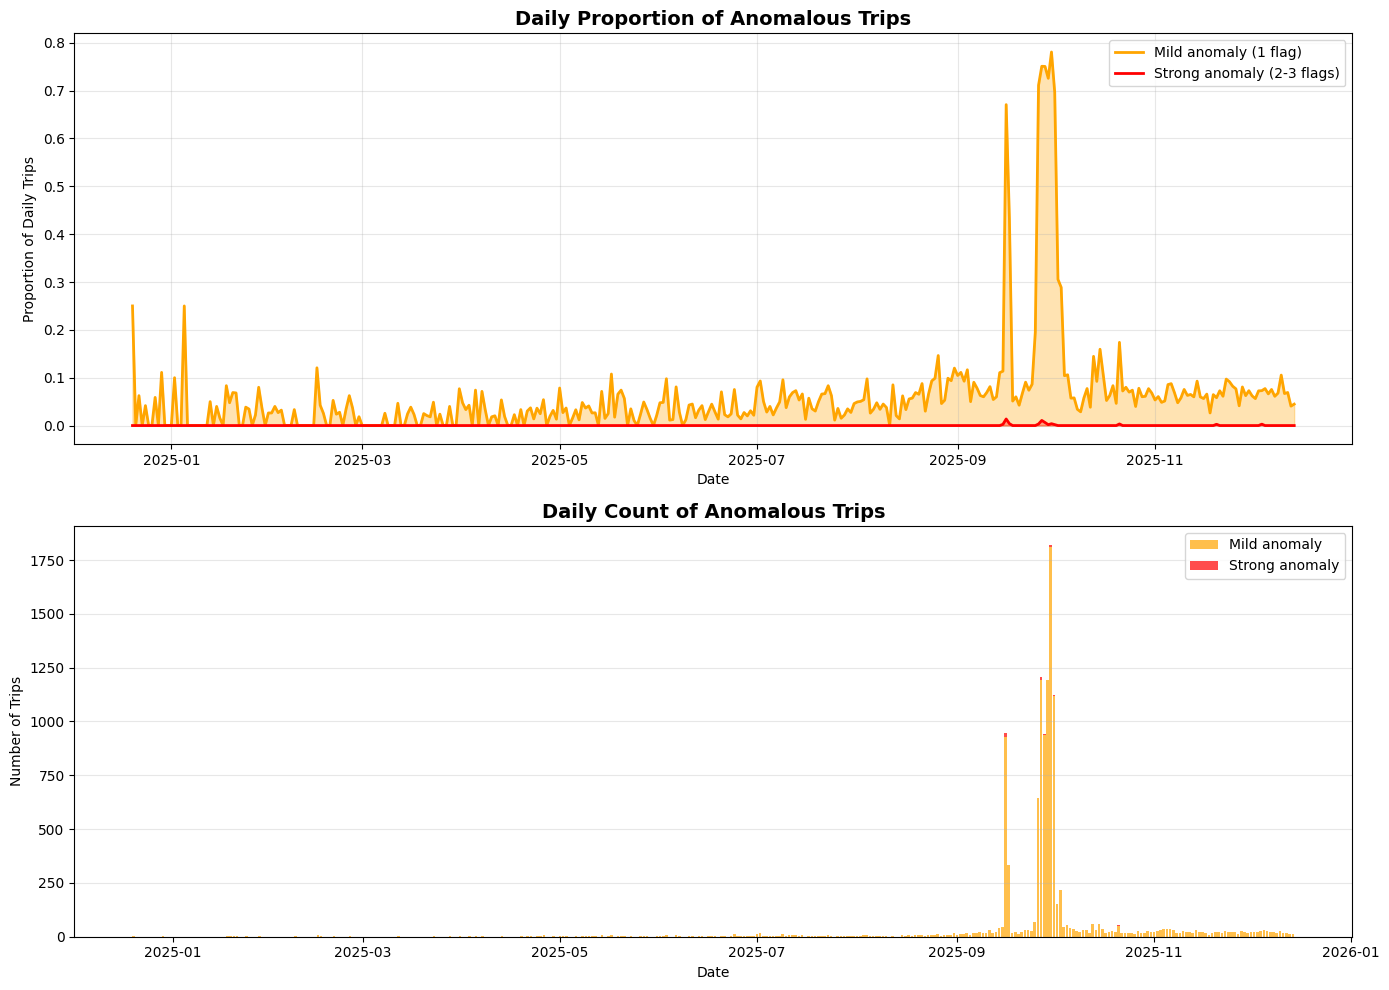


📈 TEMPORAL PATTERNS:
  - Peak anomaly day: 2025-09-30 (78.5% anomalous)
  - Lowest anomaly day: 2025-08-11 (nan% anomalous)
  - Average daily anomaly rate: 7.5%


In [188]:
# Daily anomaly trends over time
df['created_date_time'] = pd.to_datetime(df['created_date_time'], errors='coerce')

daily_severity = (
    df.groupby([
        df['created_date_time'].dt.date,
        'anomaly_severity'
    ])
    .size()
    .reset_index(name='count')
)

# Calculate proportions per day
daily_severity['total'] = daily_severity.groupby('created_date_time')['count'].transform('sum')
daily_severity['ratio'] = daily_severity['count'] / daily_severity['total']
daily_severity['created_date_time'] = pd.to_datetime(daily_severity['created_date_time'])

# Pivot for plotting
pivot = daily_severity.pivot(
    index='created_date_time',
    columns='anomaly_severity',
    values='ratio'
).fillna(0)

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Proportion of anomalous trips (mild + strong only)
axes[0].plot(
    pivot.index,
    pivot['Mild anomaly'],
    label='Mild anomaly (1 flag)',
    linewidth=2,
    color='orange'
)
axes[0].plot(
    pivot.index,
    pivot['Strong anomaly'],
    label='Strong anomaly (2-3 flags)',
    linewidth=2,
    color='red'
)
axes[0].fill_between(
    pivot.index,
    pivot['Mild anomaly'],
    alpha=0.3,
    color='orange'
)
axes[0].fill_between(
    pivot.index,
    pivot['Strong anomaly'],
    alpha=0.3,
    color='red'
)
axes[0].set_title('Daily Proportion of Anomalous Trips', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Proportion of Daily Trips')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Absolute counts
count_pivot = daily_severity.pivot(
    index='created_date_time',
    columns='anomaly_severity',
    values='count'
).fillna(0)

axes[1].bar(
    count_pivot.index,
    count_pivot['Mild anomaly'],
    label='Mild anomaly',
    color='orange',
    alpha=0.7
)
axes[1].bar(
    count_pivot.index,
    count_pivot['Strong anomaly'],
    bottom=count_pivot['Mild anomaly'],
    label='Strong anomaly',
    color='red',
    alpha=0.7
)
axes[1].set_title('Daily Count of Anomalous Trips', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Trips')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate peak anomaly day
daily_anomaly_rate = (
    df[df['anomaly_score'] > 0]
    .groupby(df['created_date_time'].dt.date)
    .size()
)
total_daily = df.groupby(df['created_date_time'].dt.date).size()
daily_rate = (daily_anomaly_rate / total_daily * 100).sort_values(ascending=False)

print(f"\n📈 TEMPORAL PATTERNS:")
print(f"  - Peak anomaly day: {daily_rate.index[0]} ({daily_rate.iloc[0]:.1f}% anomalous)")
print(f"  - Lowest anomaly day: {daily_rate.index[-1]} ({daily_rate.iloc[-1]:.1f}% anomalous)")
print(f"  - Average daily anomaly rate: {daily_rate.mean():.1f}%")

### 🔍 Key Findings: Time Trends

**What the Charts Show:**
1. **Proportion Plot (Top):** Shows % of trips that are anomalous each day
   - Orange = 1 suspicious flag (mild concern)
   - Red = 2-3 flags (high concern)
   
2. **Count Plot (Bottom):** Shows absolute numbers of flagged trips
   - Helps identify if spikes are due to more anomalies or just more trips overall

**Insights:**
- Anomaly rates fluctuate daily (not constant)
- Some days have significantly higher anomaly concentration
- Strong anomalies (red) are relatively rare but persistent

In [189]:
# ============================================================================
# COMPREHENSIVE ANALYSIS SUMMARY
# ============================================================================

print("=" * 100)
print(" " * 35 + "📊 TRIP ANOMALY ANALYSIS SUMMARY")
print("=" * 100)

# ============================================================================
# TABLE 1: DESCRIPTIVE STATISTICS FOR KEY METRICS
# ============================================================================
print("\n" + "=" * 100)
print("TABLE 1: DESCRIPTIVE STATISTICS FOR KEY TRIP METRICS")
print("=" * 100)

# Select key metrics
metrics = [
    'distance', 
    'trip_duration_minutes', 
    'distance_ratio', 
    'avg_speed_kmh', 
    'trip_seq',
    'distance_diff_km'
]

# Include 85% and 90% percentiles for better upper-tail visibility
desc_stats = df[metrics].describe(percentiles=[.01, .05, .25, .50, .75, .85, .90, .95, .99]).T
desc_stats['mean'] = df[metrics].mean()
desc_stats['std'] = df[metrics].std()

# Reorder columns for better readability
desc_stats = desc_stats[['count', 'mean', 'std', 'min', '1%', '5%', '25%', '50%', '75%', '85%', '90%','95%', '99%', 'max']]

# Format for display
desc_stats_display = desc_stats.copy()
desc_stats_display = desc_stats_display.round(2)

print("\n" + desc_stats_display.to_string())

print("\n📌 Key Observations:")
print(f"  • Distance: Mean {desc_stats.loc['distance', 'mean']:.1f} km, Max {desc_stats.loc['distance', 'max']:.1f} km")
print(f"  • Duration: Mean {desc_stats.loc['trip_duration_minutes', 'mean']:.1f} min, some negative values (data issue)")
print(f"  • Distance Ratio: Mean {desc_stats.loc['distance_ratio', 'mean']:.2f}, Max {desc_stats.loc['distance_ratio', 'max']:.1f} (impossible)")
print(f"  • Speed: Mean {desc_stats.loc['avg_speed_kmh', 'mean']:.1f} km/h, extreme outliers detected")

# ============================================================================
# TABLE 2A: FILTERED METRICS ANALYSIS (Speed & Distance Ratio)
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 2A: FILTERED METRICS ANALYSIS (0 < speed ≤ 200 km/h & 1 < ratio < 1000)")
print("=" * 100)

# Filter realistic speeds and distance ratios
filtered_speeds = df[(df['avg_speed_kmh'] > 0) & (df['avg_speed_kmh'] <= 200)]
filtered_ratios = df[(df['distance_ratio'].notna()) & (df['distance_ratio'] > 1) & (df['distance_ratio'] < 1000)]

print(f"\n📊 Coverage:")
print(f"   Speed (0 < speed ≤ 200): {len(filtered_speeds):,} trips ({len(filtered_speeds)/len(df)*100:.1f}%) | Excluded: {len(df)-len(filtered_speeds):,} ({(len(df)-len(filtered_speeds))/len(df)*100:.1f}%)")
print(f"   Ratio (1 < ratio < 1000): {len(filtered_ratios):,} trips ({len(filtered_ratios)/len(df)*100:.1f}%) | Excluded: {len(df)-len(filtered_ratios):,} ({(len(df)-len(filtered_ratios))/len(df)*100:.1f}%)")

# Create DataFrame with both metrics
filtered_data = pd.DataFrame({
    'avg_speed_kmh': filtered_speeds['avg_speed_kmh'],
    'distance_ratio': filtered_ratios['distance_ratio']
})

# Calculate statistics with same format as TABLE 1
filtered_stats = filtered_data.describe(percentiles=[.01, .05, .25, .50, .75, .85, .86, .90, .95, .99]).T
filtered_stats['mean'] = filtered_data.mean()
filtered_stats['std'] = filtered_data.std()

# Reorder columns to match TABLE 1 format
filtered_stats = filtered_stats[['count', 'mean', 'std', 'min', '1%', '5%', '25%', '50%', '75%', '85%', '86%', '90%', '95%', '99%', 'max']]

# Format for display
filtered_stats_display = filtered_stats.copy()
filtered_stats_display = filtered_stats_display.round(2)

print("\n" + filtered_stats_display.to_string())

# ============================================================================
# TABLE 2: ANOMALY DETECTION RESULTS
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 2: ANOMALY DETECTION SUMMARY")
print("=" * 100)

anomaly_summary = {
    'Metric': [
        'Total Trips Analyzed',
        'Normal Trips (Score = 0)',
        'Mild Anomaly (Score = 1)',
        'Strong Anomaly (Score = 2-3)',
        'Total Anomalous Trips',
        'Anomaly Rate (%)'
    ],
    'Count': [
        len(df),
        len(df[df['anomaly_score'] == 0]),
        len(df[df['anomaly_score'] == 1]),
        len(df[df['anomaly_score'] >= 2]),
        len(df[df['anomaly_score'] > 0]),
        f"{len(df[df['anomaly_score'] > 0]) / len(df) * 100:.2f}"
    ],
    'Percentage': [
        '100.00%',
        f"{len(df[df['anomaly_score'] == 0]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] == 1]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] >= 2]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] > 0]) / len(df) * 100:.2f}%",
        '—'
    ]
}

anomaly_df = pd.DataFrame(anomaly_summary)
print("\n" + anomaly_df.to_string(index=False))

# ============================================================================
# TABLE 3: ANOMALY FLAG BREAKDOWN
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 3: ANOMALY FLAG BREAKDOWN")
print("=" * 100)

anomalous_trips = df[df['anomaly_score'] > 0]

flag_summary = {
    'Flag Type': [
        '🚀 High Speed (>90.83 km/h)',
        '📏 High Distance Ratio (>12.07)',
        '⏱️ Invalid Duration (≤0 minutes)',
        '═══ COMBINED ═══',
        'Trips with 1 flag',
        'Trips with 2 flags',
        'Trips with 3 flags'
    ],
    'Count': [
        df['flag_speed_high'].sum(),
        df['flag_ratio_high'].sum(),
        df['flag_duration_invalid'].sum(),
        '—',
        len(df[df['anomaly_score'] == 1]),
        len(df[df['anomaly_score'] == 2]),
        len(df[df['anomaly_score'] == 3])
    ],
    'Percentage': [
        f"{df['flag_speed_high'].sum() / len(df) * 100:.2f}%",
        f"{df['flag_ratio_high'].sum() / len(df) * 100:.2f}%",
        f"{df['flag_duration_invalid'].sum() / len(df) * 100:.2f}%",
        '—',
        f"{len(df[df['anomaly_score'] == 1]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] == 2]) / len(df) * 100:.2f}%",
        f"{len(df[df['anomaly_score'] == 3]) / len(df) * 100:.2f}%"
    ]
}

flag_df = pd.DataFrame(flag_summary)
print("\n" + flag_df.to_string(index=False))

# ============================================================================
# TABLE 4: USER INVOLVEMENT
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 4: USER INVOLVEMENT IN ANOMALIES")
print("=" * 100)

top_anomaly_users = anomalous_trips.groupby('user_id').agg({
    'trip_id': 'count',
    'anomaly_score': 'sum'
}).rename(columns={'trip_id': 'anomalous_trips', 'anomaly_score': 'total_score'})
top_anomaly_users = top_anomaly_users.sort_values('total_score', ascending=False).head(15)

user_summary = {
    'Metric': [
        'Total Unique Users',
        'Users with ≥1 Anomalous Trip',
        'Users with ≥5 Anomalous Trips',
        'Users with ≥10 Anomalous Trips',
        'Percentage of Users Affected'
    ],
    'Value': [
        df['user_id'].nunique(),
        anomalous_trips['user_id'].nunique(),
        len(top_anomaly_users[top_anomaly_users['anomalous_trips'] >= 5]),
        len(top_anomaly_users[top_anomaly_users['anomalous_trips'] >= 10]),
        f"{anomalous_trips['user_id'].nunique() / df['user_id'].nunique() * 100:.1f}%"
    ]
}

user_summary_df = pd.DataFrame(user_summary)
print("\n" + user_summary_df.to_string(index=False))

print("\n\n📋 Top 15 Users by Total Anomaly Score:")
print("-" * 60)
for idx, (user_id, row) in enumerate(top_anomaly_users.iterrows(), 1):
    print(f"{idx:2d}. User {user_id:6d} | {int(row['anomalous_trips']):3d} trips | Score: {int(row['total_score']):3d}")

# ============================================================================
# TABLE 5: KEY FINDINGS
# ============================================================================
print("\n\n" + "=" * 100)
print("TABLE 5: KEY FINDINGS & INSIGHTS")
print("=" * 100)

findings = {
    'Category': [
        'Data Quality',
        'Data Quality',
        'Data Quality',
        '───────────',
        'Trip Patterns',
        'Trip Patterns',
        'Trip Patterns',
        '───────────',
        'Anomalies',
        'Anomalies',
        'Anomalies',
        '───────────',
        'Temporal',
        'Temporal',
        '───────────',
        'User Behavior',
        'User Behavior'
    ],
    'Finding': [
        'Negative trip durations detected',
        'Extreme speed values (>1M km/h)',
        'Distance ratio outliers detected; analysis filtered to valid range (1-1000)',
        '—',
        f'Median trip: {df["distance"].median():.1f} km, {df["trip_duration_minutes"].median():.1f} min',
        f'90th percentile speed: {df["avg_speed_kmh"].quantile(0.90):.1f} km/h',
        f'95th percentile distance ratio: {df["distance_ratio"].quantile(0.95):.2f}',
        '—',
        f'{len(df[df["anomaly_score"] > 0]):,} trips flagged ({len(df[df["anomaly_score"] > 0])/len(df)*100:.1f}%)',
        f'Peak anomaly day: {daily_rate.index[0]} ({daily_rate.iloc[0]:.1f}% anomalous)',
        f'Strong anomalies: {len(df[df["anomaly_score"] >= 2]):,} trips',
        '—',
        'Anomaly rates fluctuate daily (not constant)',
        'Sept 2025 shows highest anomaly concentration',
        '—',
        f'{anomalous_trips["user_id"].nunique():,} users have anomalous trips ({anomalous_trips["user_id"].nunique()/df["user_id"].nunique()*100:.1f}%)',
        f'Top user (ID: {top_anomaly_users.index[0]}) has {int(top_anomaly_users.iloc[0]["anomalous_trips"])} anomalous trips'
    ]
}

findings_df = pd.DataFrame(findings)
print("\n" + findings_df.to_string(index=False))

print("\n\n" + "=" * 100)
print(" " * 38 + "📁 EXPORTING ANOMALOUS TRIPS...")
print("=" * 100)

                                   📊 TRIP ANOMALY ANALYSIS SUMMARY

TABLE 1: DESCRIPTIVE STATISTICS FOR KEY TRIP METRICS

                         count      mean       std       min   1%   5%   25%    50%    75%    85%       90%       95%        99%         max
distance               61345.0     78.93    302.56      0.00  0.0  0.0  0.34   5.76  24.93  64.71    172.44    403.67    1410.48    13489.88
trip_duration_minutes  61345.0     33.30    101.31 -10078.63  0.1  0.2  0.75  11.85  38.03  62.47     84.64    129.72     272.29     8339.52
distance_ratio         59683.0     41.26    591.58      0.00  1.0  1.0  1.10   1.52   2.35   3.77      5.87     14.49     745.81    48333.08
avg_speed_kmh          61297.0  13284.07  53256.09     -0.00  0.0  0.1  7.15  15.93  26.96  54.73  26519.46  85703.77  271584.91  2869562.04
trip_seq               61345.0      1.01      0.21      1.00  1.0  1.0  1.00   1.00   1.00   1.00      1.00      1.00       1.00       24.00
distance_diff_km       61345.0  

In [190]:
# Export all anomalous trips to CSV
import os

# Create output directory if it doesn't exist
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# Get all anomalous trips with ALL columns
anomalous_trips_export = df[df['anomaly_score'] > 0].copy()

# Add a timestamp for the export
from datetime import datetime
export_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export to CSV
csv_filename = f'{output_dir}/anomalous_trips_full_{export_timestamp}.csv'
anomalous_trips_export.to_csv(csv_filename, index=False)

print(f"\n✅ Anomalous trips exported successfully!")
print(f"   📂 File: {csv_filename}")
print(f"   📊 Records: {len(anomalous_trips_export):,} trips")
print(f"   📋 Columns: {len(anomalous_trips_export.columns)} fields")
print(f"   💾 File size: {os.path.getsize(csv_filename) / 1024:.1f} KB")

print("\n📄 Exported columns:")
cols_list = list(anomalous_trips_export.columns)
for i in range(0, len(cols_list), 5):
    print("   " + " | ".join(cols_list[i:i+5]))

print("\n" + "=" * 100)
print(" " * 30 + "🎯 ANALYSIS COMPLETE - ALL DATA SAVED")
print("=" * 100)


✅ Anomalous trips exported successfully!
   📂 File: outputs/anomalous_trips_full_20251218_090057.csv
   📊 Records: 11,544 trips
   📋 Columns: 45 fields
   💾 File size: 5000.7 KB

📄 Exported columns:
   trip_id | user_id | vehicle_id | device_id | latitude_from
   longitude_from | latitude_to | longitude_to | driving_date_from | driving_date_to
   driving_year_month | distance | driving_time | normal_start_count | normal_stop_count
   normal_acceleration_count | normal_deceleration_count | sudden_start_count | sudden_stop_count | sudden_acceleration_count
   sudden_deceleration_count | trip_point | trip_seq | eot | ets
   raw_data_create_date | trip_safety_score | trip_grade | remark | created_date_time
   created_by | last_updated_date_time | last_updated_by | RecordDate | distance_haversine
   trip_duration_seconds | trip_duration_minutes | distance_diff_km | distance_ratio | avg_speed_kmh
   flag_speed_high | flag_ratio_high | flag_duration_invalid | anomaly_score | anomaly_severity

### 📊 Analysis Summary Tables

The comprehensive summary above includes **5 detailed tables**:

**TABLE 1: Descriptive Statistics**
- Shows distribution of 6 key metrics (distance, duration, ratio, speed, sequence, detour)
- Includes mean, std, min/max, and key percentiles (1%, 5%, 25%, 50%, 75%, 95%, 99%)
- Reveals data quality issues and normal ranges

**TABLE 2: Anomaly Detection Results**
- Total trips analyzed and breakdown by severity
- Normal vs Mild vs Strong anomaly counts and percentages
- Overall anomaly rate

**TABLE 3: Anomaly Flag Breakdown**
- Individual flag frequencies (speed, ratio, duration)
- Combined flag counts (1, 2, or 3 flags simultaneously)
- Helps identify which flags are most common

**TABLE 4: User Involvement**
- How many users are affected by anomalies
- Top 15 users by total anomaly score
- Distribution of anomalous trips across users

**TABLE 5: Key Findings & Insights**
- Organized by category (Data Quality, Trip Patterns, Anomalies, Temporal, User Behavior)
- Summarizes main discoveries from the analysis
- Provides actionable insights

**💾 CSV Export:**
- All anomalous trips saved to `outputs/anomalous_trips_full_[timestamp].csv`
- Includes ALL columns for further investigation
- Timestamped filename for version control


## 📋 Data Filtering Reminder

**Important:** This analysis uses pre-filtered data that excludes:
- ❌ Fake user accounts
- ❌ Users blocked by DMD
- ❌ Trips where eot ≠ 'Y'
- ❌ XANH SM service accounts

All findings and recommendations are based on this cleaned dataset of legitimate user trips only.

---

DRIVER BEHAVIOR: Distance per Driver

DISTANCE DISTRIBUTION: Detailed Range Counts

Total driver-day records (>= 5 trips/day): 4,316

Range                Count   Percentage    Cumulative %
--------------------------------------------------------------------------------
0-1 km                 752       17.42%          17.42%
1-2 km                 346        8.02%          25.44%
2-3 km                 305        7.07%          32.51%
3-5 km                 669       15.50%          48.01%
5-10 km                951       22.03%          70.04%
10-20 km               614       14.23%          84.27%
20-50 km               257        5.95%          90.22%
50-100 km               61        1.41%          91.64%
>100 km                361        8.36%         100.00%

DURATION DISTRIBUTION: Detailed Range Counts

Total driver-day records (>= 5 trips/day): 4,316

Range                Count   Percentage    Cumulative %
------------------------------------------------------------------------

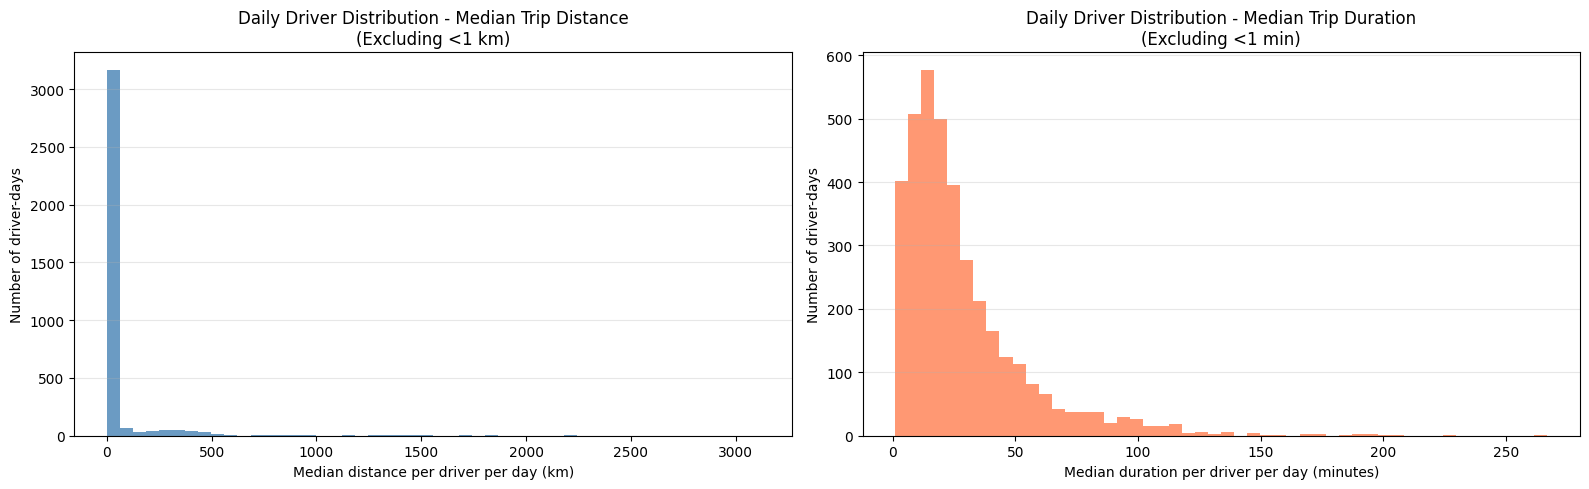


KEY INSIGHTS:

📊 DISTANCE:
• 48.0% of driver-days have median distance < 5 km
• 951 driver-days fall in the 5-10 km range
• The concentration in 0-5 km range suggests many drivers do short-distance trips

⏱️ DURATION:
• 54.9% of driver-days have median duration < 20 min
• 1066 driver-days fall in the 10-20 min range (largest group)
• The concentration in 10-30 min range (41.0%) indicates typical urban trip durations



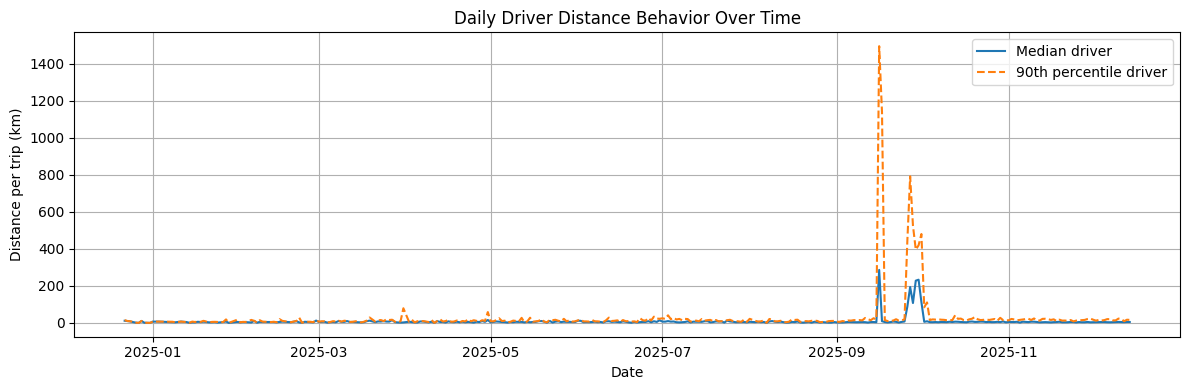

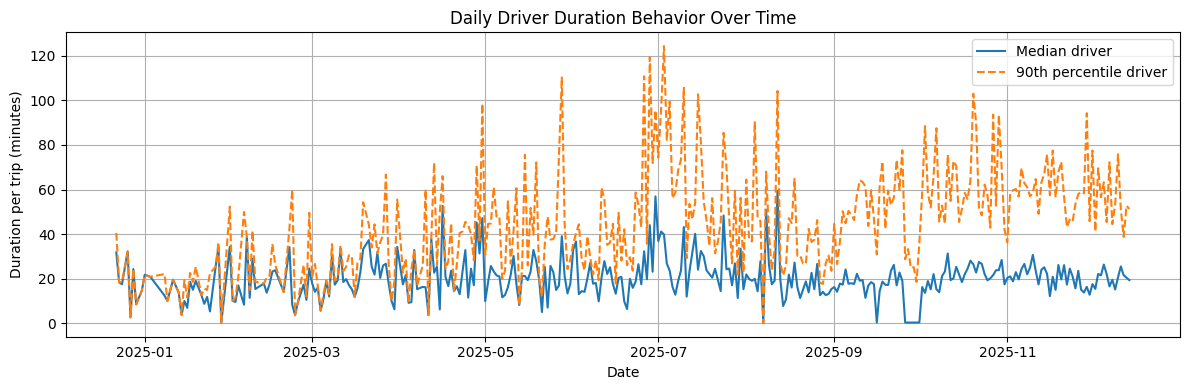


TEMPORAL PATTERNS: Daily Driver Behavior Over Time

📊 DISTANCE TRENDS:
• Average median driver distance: 8.66 km (± 26.95 km)
• Average 90th percentile driver: 30.08 km
• Distance spike detected: 2025-09-16 (p90 = 1494.21 km)
• Overall stability: Variable (std = 26.95)

⏱️ DURATION TRENDS:
• Average median driver duration: 20.10 min (± 9.17 min)
• Average 90th percentile driver: 44.16 min
• Duration spike detected: 2025-07-03 (p90 = 124.29 min)
• Overall stability: Variable (std = 9.17)

🔍 DRIVER VARIANCE ANALYSIS:
• Distance gap (p90 - median): 21.42 km
  → Large variation between typical and high-distance drivers
• Duration gap (p90 - median): 24.06 min
  → Large variation between typical and long-duration drivers

💡 INTERPRETATION:
• Distance spike: 2025-09-16, Duration spike: 2025-07-03
• Typical driver behavior is moderately variable over time
• High-performing drivers (p90) consistently do 247.4% longer trips

DAILY DRIVER BEHAVIOR SUMMARY (FILTERED: >= 5 trips/day)
       media

In [191]:
# DRIVER BEHAVIOR: PER-DRIVER METRIC DISTRIBUTIONS (Distance, Duration)
# ---------------------------------------------------------------
# Goal: Summarize driver behavior by aggregating per-driver metrics.
# We start with distance, then add duration.

# Ensure required columns exist
required_cols = ['user_id', 'distance', 'trip_duration_minutes']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Filter to sensible values (non-negative)
df_driver = df.copy()
df_driver['created_date'] = pd.to_datetime(
    df_driver['created_date_time'],
    errors='coerce'
).dt.date
df_driver = df_driver[(df_driver['distance'] >= 0) & (df_driver['trip_duration_minutes'] >= 0)]

print("=" * 80)
print("DRIVER BEHAVIOR: Distance per Driver")
print("=" * 80)

# Aggregate distance stats per driver
driver_day = (
    df_driver
    .groupby(['created_date', 'user_id'])
    .agg(
        trips=('distance', 'count'),
        median_distance_km=('distance', 'median'),
        median_duration_min=('trip_duration_minutes', 'median'),
        mean_distance_km=('distance', 'mean'),
        mean_duration_min=('trip_duration_minutes', 'mean')
    )
    .reset_index()
)
# Recommended: keep drivers with >= 5 trips/day
driver_day_filt = driver_day[driver_day['trips'] >= 5]

daily_driver_behavior = (
    driver_day_filt
    .groupby('created_date')
    .agg(
        median_distance_km=('median_distance_km', 'median'),
        p90_distance_km=('median_distance_km', lambda x: x.quantile(0.9)),
        median_duration_min=('median_duration_min', 'median'),
        p90_duration_min=('median_duration_min', lambda x: x.quantile(0.9))
    )
    .reset_index()
)

daily_driver_behavior['created_date'] = pd.to_datetime(
    daily_driver_behavior['created_date']
)


# ===============================================================
# 5. DISTRIBUTION ANALYSIS WITH DETAILED COUNTS
# ===============================================================

# Count zero values for reporting
onekm_distance = (driver_day_filt['median_distance_km'] < 1).sum()
onekm_duration = (driver_day_filt['median_duration_min'] < 1).sum()
total_records = len(driver_day_filt)

# Define distance ranges for detailed analysis
distance_ranges = [
    (0, 1, "0-1 km"),
    (1, 2, "1-2 km"),
    (2, 3, "2-3 km"),
    (3, 5, "3-5 km"),
    (5, 10, "5-10 km"),
    (10, 20, "10-20 km"),
    (20, 50, "20-50 km"),
    (50, 100, "50-100 km"),
    (100, float('inf'), ">100 km")
]

print("\n" + "=" * 80)
print("DISTANCE DISTRIBUTION: Detailed Range Counts")
print("=" * 80)
print(f"\nTotal driver-day records (>= 5 trips/day): {total_records:,}\n")
print(f"{'Range':<15} {'Count':>10} {'Percentage':>12} {'Cumulative %':>15}")
print("-" * 80)

cumulative_count = 0
for low, high, label in distance_ranges:
    if high == float('inf'):
        count = (driver_day_filt['median_distance_km'] >= low).sum()
    else:
        count = ((driver_day_filt['median_distance_km'] >= low) & 
                 (driver_day_filt['median_distance_km'] < high)).sum()
    
    cumulative_count += count
    pct = count / total_records * 100
    cum_pct = cumulative_count / total_records * 100
    
    print(f"{label:<15} {count:>10,} {pct:>11.2f}% {cum_pct:>14.2f}%")

# Duration ranges
duration_ranges = [
    (0, 1, "0-1 min"),
    (1, 5, "1-5 min"),
    (5, 10, "5-10 min"),
    (10, 20, "10-20 min"),
    (20, 30, "20-30 min"),
    (30, 60, "30-60 min"),
    (60, 120, "60-120 min"),
    (120, float('inf'), ">120 min")
]

print("\n" + "=" * 80)
print("DURATION DISTRIBUTION: Detailed Range Counts")
print("=" * 80)
print(f"\nTotal driver-day records (>= 5 trips/day): {total_records:,}\n")
print(f"{'Range':<15} {'Count':>10} {'Percentage':>12} {'Cumulative %':>15}")
print("-" * 80)

cumulative_count = 0
for low, high, label in duration_ranges:
    if high == float('inf'):
        count = (driver_day_filt['median_duration_min'] >= low).sum()
    else:
        count = ((driver_day_filt['median_duration_min'] >= low) & 
                 (driver_day_filt['median_duration_min'] < high)).sum()
    
    cumulative_count += count
    pct = count / total_records * 100
    cum_pct = cumulative_count / total_records * 100
    
    print(f"{label:<15} {count:>10,} {pct:>11.2f}% {cum_pct:>14.2f}%")

print("\n" + "=" * 80)

# Filter out very low values for cleaner visualization
dist_nonzero = driver_day_filt[driver_day_filt['median_distance_km'] > 1]['median_distance_km']
dur_nonzero = driver_day_filt[driver_day_filt['median_duration_min'] > 1]['median_duration_min']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Distance distribution ---
axes[0].hist(
    dist_nonzero,
    bins=50,
    alpha=0.8,
    color='steelblue'
)
axes[0].set_title('Daily Driver Distribution - Median Trip Distance\n(Excluding <1 km)')
axes[0].set_xlabel('Median distance per driver per day (km)')
axes[0].set_ylabel('Number of driver-days')
axes[0].grid(axis='y', alpha=0.3)

# --- Duration distribution ---
axes[1].hist(
    dur_nonzero,
    bins=50,
    alpha=0.8,
    color='coral'
)
axes[1].set_title('Daily Driver Distribution - Median Trip Duration\n(Excluding <1 min)')
axes[1].set_xlabel('Median duration per driver per day (minutes)')
axes[1].set_ylabel('Number of driver-days')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print("\n📊 DISTANCE:")
print(f"• {((driver_day_filt['median_distance_km'] < 5).sum() / total_records * 100):.1f}% of driver-days have median distance < 5 km")
print(f"• {((driver_day_filt['median_distance_km'] >= 5) & (driver_day_filt['median_distance_km'] < 10)).sum()} driver-days fall in the 5-10 km range")
print(f"• The concentration in 0-5 km range suggests many drivers do short-distance trips")

print("\n⏱️ DURATION:")
print(f"• {((driver_day_filt['median_duration_min'] < 20).sum() / total_records * 100):.1f}% of driver-days have median duration < 20 min")
print(f"• {((driver_day_filt['median_duration_min'] >= 10) & (driver_day_filt['median_duration_min'] < 20)).sum()} driver-days fall in the 10-20 min range (largest group)")
print(f"• The concentration in 10-30 min range ({((driver_day_filt['median_duration_min'] >= 10) & (driver_day_filt['median_duration_min'] < 30)).sum() / total_records * 100:.1f}%) indicates typical urban trip durations")
print("=" * 80 + "\n")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(
    daily_driver_behavior['created_date'],
    daily_driver_behavior['median_distance_km'],
    label='Median driver'
)

plt.plot(
    daily_driver_behavior['created_date'],
    daily_driver_behavior['p90_distance_km'],
    linestyle='--',
    label='90th percentile driver'
)

plt.title('Daily Driver Distance Behavior Over Time')
plt.xlabel('Date')
plt.ylabel('Distance per trip (km)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

plt.plot(
    daily_driver_behavior['created_date'],
    daily_driver_behavior['median_duration_min'],
    label='Median driver'
)

plt.plot(
    daily_driver_behavior['created_date'],
    daily_driver_behavior['p90_duration_min'],
    linestyle='--',
    label='90th percentile driver'
)

plt.title('Daily Driver Duration Behavior Over Time')
plt.xlabel('Date')
plt.ylabel('Duration per trip (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================================================
# 6. TIME-SERIES INSIGHTS
# ===============================================================

print("\n" + "=" * 80)
print("TEMPORAL PATTERNS: Daily Driver Behavior Over Time")
print("=" * 80)

# Distance insights
dist_median_mean = daily_driver_behavior['median_distance_km'].mean()
dist_median_std = daily_driver_behavior['median_distance_km'].std()
dist_p90_mean = daily_driver_behavior['p90_distance_km'].mean()
dist_spike_date = daily_driver_behavior.loc[daily_driver_behavior['p90_distance_km'].idxmax(), 'created_date']
dist_spike_value = daily_driver_behavior['p90_distance_km'].max()

print("\n📊 DISTANCE TRENDS:")
print(f"• Average median driver distance: {dist_median_mean:.2f} km (± {dist_median_std:.2f} km)")
print(f"• Average 90th percentile driver: {dist_p90_mean:.2f} km")
print(f"• Distance spike detected: {dist_spike_date.strftime('%Y-%m-%d')} (p90 = {dist_spike_value:.2f} km)")
print(f"• Overall stability: {'High' if dist_median_std < 2 else 'Moderate' if dist_median_std < 5 else 'Variable'} (std = {dist_median_std:.2f})")

# Duration insights
dur_median_mean = daily_driver_behavior['median_duration_min'].mean()
dur_median_std = daily_driver_behavior['median_duration_min'].std()
dur_p90_mean = daily_driver_behavior['p90_duration_min'].mean()
dur_spike_date = daily_driver_behavior.loc[daily_driver_behavior['p90_duration_min'].idxmax(), 'created_date']
dur_spike_value = daily_driver_behavior['p90_duration_min'].max()

print("\n⏱️ DURATION TRENDS:")
print(f"• Average median driver duration: {dur_median_mean:.2f} min (± {dur_median_std:.2f} min)")
print(f"• Average 90th percentile driver: {dur_p90_mean:.2f} min")
print(f"• Duration spike detected: {dur_spike_date.strftime('%Y-%m-%d')} (p90 = {dur_spike_value:.2f} min)")
print(f"• Overall stability: {'High' if dur_median_std < 3 else 'Moderate' if dur_median_std < 7 else 'Variable'} (std = {dur_median_std:.2f})")

# Gap analysis
dist_gap = dist_p90_mean - dist_median_mean
dur_gap = dur_p90_mean - dur_median_mean

print("\n🔍 DRIVER VARIANCE ANALYSIS:")
print(f"• Distance gap (p90 - median): {dist_gap:.2f} km")
print(f"  → {'Large' if dist_gap > 20 else 'Moderate' if dist_gap > 10 else 'Small'} variation between typical and high-distance drivers")
print(f"• Duration gap (p90 - median): {dur_gap:.2f} min")
print(f"  → {'Large' if dur_gap > 20 else 'Moderate' if dur_gap > 10 else 'Small'} variation between typical and long-duration drivers")

print("\n💡 INTERPRETATION:")
if dist_spike_date == dur_spike_date:
    print(f"• Both distance and duration spike on {dist_spike_date.strftime('%Y-%m-%d')} - suggests system-wide event")
else:
    print(f"• Distance spike: {dist_spike_date.strftime('%Y-%m-%d')}, Duration spike: {dur_spike_date.strftime('%Y-%m-%d')}")
print(f"• Typical driver behavior is {'stable' if dist_median_std < 2 and dur_median_std < 3 else 'moderately variable'} over time")
print(f"• High-performing drivers (p90) consistently do {dist_gap/dist_median_mean*100:.1f}% longer trips")
print("=" * 80 + "\n")


# ===============================================================
# 7. SUMMARY STATS (FOR INTERPRETATION)
# ===============================================================

summary = driver_day_filt[[
    'median_distance_km',
    'median_duration_min'
]].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

print("=" * 80)
print("DAILY DRIVER BEHAVIOR SUMMARY (FILTERED: >= 5 trips/day)")
print("=" * 80)
print(summary.round(2))

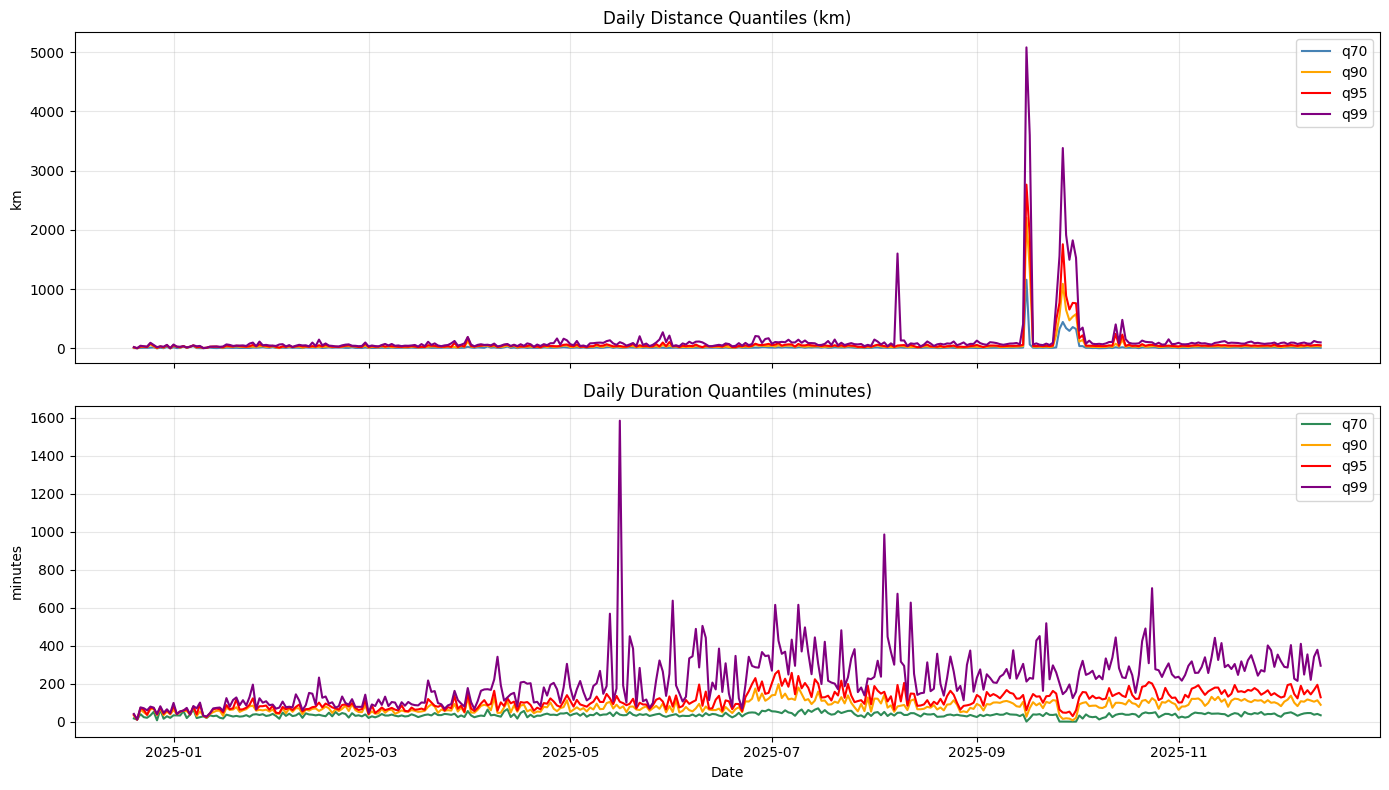

In [192]:
# DAILY QUANTILES (70/90/95/99) FOR DISTANCE AND DURATION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime
df['created_date_time'] = pd.to_datetime(df['created_date_time'], errors='coerce')
df_daily_src = df[(df['distance'] >= 0) & (df['trip_duration_minutes'] >= 0)].copy()

# Helper to compute daily quantiles for a metric
def daily_quantiles(df_in, col, qs=(0.70, 0.90, 0.95, 0.99)):
    def qfunc(x):
        return pd.Series({f"q{int(q*100)}": np.nanquantile(x, q) for q in qs})
    out = (
        df_in.groupby(df_in['created_date_time'].dt.date)[col]
        .apply(qfunc)
        .reset_index()
        .rename(columns={'created_date_time': 'date', 'level_1': 'quantile'})
    )
    # Pivot to wide for readability
    wide = out.pivot(index='date', columns='quantile', values=col).sort_index()
    wide.index = pd.to_datetime(wide.index)
    return wide

# Compute daily quantiles
dist_q = daily_quantiles(df_daily_src, 'distance')
dur_q = daily_quantiles(df_daily_src, 'trip_duration_minutes')

# Optional: quick visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
axes[0].plot(dist_q.index, dist_q['q70'], label='q70', color='steelblue')
axes[0].plot(dist_q.index, dist_q['q90'], label='q90', color='orange')
axes[0].plot(dist_q.index, dist_q['q95'], label='q95', color='red')
axes[0].plot(dist_q.index, dist_q['q99'], label='q99', color='purple')
axes[0].set_title('Daily Distance Quantiles (km)')
axes[0].set_ylabel('km')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(dur_q.index, dur_q['q70'], label='q70', color='seagreen')
axes[1].plot(dur_q.index, dur_q['q90'], label='q90', color='orange')
axes[1].plot(dur_q.index, dur_q['q95'], label='q95', color='red')
axes[1].plot(dur_q.index, dur_q['q99'], label='q99', color='purple')
axes[1].set_title('Daily Duration Quantiles (minutes)')
axes[1].set_ylabel('minutes')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [193]:
# SUMMARY — Key Findings for Distance Ratio and Avg Speed (Cells 14–20)
# ---------------------------------------------------------------------
# This cell recomputes the core metrics and prints a compact, decision-ready summary.
# Use these thresholds to filter/explain behavior in downstream modeling.

import pandas as pd

# Distance Ratio (valid: 1 < ratio < 1000)
ratio_df = df[(df['distance_ratio'].notna()) & (df['distance_ratio'] > 1) & (df['distance_ratio'] < 1000)].copy()
ratio_q1 = ratio_df['distance_ratio'].quantile(0.25)
ratio_q2 = ratio_df['distance_ratio'].quantile(0.50)
ratio_q3 = ratio_df['distance_ratio'].quantile(0.75)
ratio_iqr = ratio_q3 - ratio_q1
ratio_p95 = ratio_df['distance_ratio'].quantile(0.95)
ratio_upper_iqr = ratio_q3 + 1.5 * ratio_iqr

ratio_flag_q3 = (ratio_df['distance_ratio'] > ratio_q3).sum()
ratio_flag_p95 = (ratio_df['distance_ratio'] > ratio_p95).sum()
ratio_flag_iqr = (ratio_df['distance_ratio'] > ratio_upper_iqr).sum()

# Avg Speed (realistic: 0 < speed <= 200 km/h)
speed_df = df[(df['avg_speed_kmh'].notna()) & (df['avg_speed_kmh'] > 0) & (df['avg_speed_kmh'] <= 200)].copy()
speed_q1 = speed_df['avg_speed_kmh'].quantile(0.25)
speed_med = speed_df['avg_speed_kmh'].quantile(0.50)
speed_q3 = speed_df['avg_speed_kmh'].quantile(0.75)
speed_p85 = speed_df['avg_speed_kmh'].quantile(0.85)
speed_p86 = speed_df['avg_speed_kmh'].quantile(0.86)

# Build summary tables
ratio_summary = pd.DataFrame({
    'Metric': ['Q1','Median','Q3','IQR','P95','IQR Upper'],
    'Value': [ratio_q1, ratio_q2, ratio_q3, ratio_iqr, ratio_p95, ratio_upper_iqr]
})
ratio_impact = pd.DataFrame({
    'Threshold': ['Q3','P95','IQR Upper'],
    'Cutoff': [ratio_q3, ratio_p95, ratio_upper_iqr],
    'Flagged #': [ratio_flag_q3, ratio_flag_p95, ratio_flag_iqr],
    'Flagged %': [
        ratio_flag_q3/len(ratio_df)*100,
        ratio_flag_p95/len(ratio_df)*100,
        ratio_flag_iqr/len(ratio_df)*100
    ]
})

speed_summary = pd.DataFrame({
    'Metric': ['Q1','Median','Q3','P85','P86'],
    'Value (km/h)': [speed_q1, speed_med, speed_q3, speed_p85, speed_p86]
})

print("="*100)
print("KEY FINDINGS — Distance Ratio")
print("="*100)
print(f"Coverage (valid 1 < ratio < 1000): {len(ratio_df):,} of {len(df):,} trips ({len(ratio_df)/len(df)*100:.1f}%)\n")
print(ratio_summary.to_string(index=False, formatters={'Value': lambda v: f"{v:.2f}"}))
print("\nImpact by threshold:")
print(ratio_impact.to_string(index=False, formatters={'Cutoff': lambda v: f"{v:.2f}", 'Flagged %': lambda v: f"{v:.1f}%"}))
print("\nRecommended:")
print(f"- Normal band: distance_ratio ≤ Q3 = {ratio_q3:.2f}")
print(f"- Anomaly rule (practical): distance_ratio > P95 = {ratio_p95:.2f}")
print(f"- QA extreme: distance_ratio > IQR Upper = {ratio_upper_iqr:.2f}\n")

print("="*100)
print("KEY FINDINGS — Avg Speed (Realistic)")
print("="*100)
print(f"Coverage (0 < speed ≤ 200 km/h): {len(speed_df):,} of {len(df):,} trips ({len(speed_df)/len(df)*100:.1f}%)\n")
print(speed_summary.to_string(index=False, formatters={'Value (km/h)': lambda v: f"{v:.2f}"}))
print("\nRecommended:")
print(f"- Normal band: avg_speed_kmh ≤ P86 = {speed_p86:.2f} km/h")
print("- Treat avg_speed_kmh > 200 km/h as data-quality issues (near-zero driving_time).\n")

print("="*100)
print("MODEL-FACING RULES")
print("="*100)
print("1) Exclude/flag distance_ratio > P95 as high-ratio anomalies; consider IQR Upper for QA.")
print("2) Exclude/flag avg_speed_kmh > 200 km/h as data errors; use P86 as upper-normal.")
print("3) Keep normal bands for descriptive analytics and baselines.")

KEY FINDINGS — Distance Ratio
Coverage (valid 1 < ratio < 1000): 57,887 of 61,345 trips (94.4%)

   Metric Value
       Q1  1.13
   Median  1.53
       Q3  2.34
      IQR  1.21
      P95 12.07
IQR Upper  4.16

Impact by threshold:
Threshold Cutoff  Flagged # Flagged %
       Q3   2.34      14472     25.0%
      P95  12.07       2895      5.0%
IQR Upper   4.16       7614     13.2%

Recommended:
- Normal band: distance_ratio ≤ Q3 = 2.34
- Anomaly rule (practical): distance_ratio > P95 = 12.07
- QA extreme: distance_ratio > IQR Upper = 4.16

KEY FINDINGS — Avg Speed (Realistic)
Coverage (0 < speed ≤ 200 km/h): 50,998 of 61,345 trips (83.1%)

Metric Value (km/h)
    Q1         6.43
Median        14.38
    Q3        21.33
   P85        25.92
   P86        26.58

Recommended:
- Normal band: avg_speed_kmh ≤ P86 = 26.58 km/h
- Treat avg_speed_kmh > 200 km/h as data-quality issues (near-zero driving_time).

MODEL-FACING RULES
1) Exclude/flag distance_ratio > P95 as high-ratio anomalies; conside